In [2]:
pip install prince


^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/22.9 MB ? eta -:--:--
   ---------------- ----------------------- 9.7/22.9 MB 49.4 MB/s eta 0:00:01
   --------------------------------- ------ 19.1/22.9 MB 48.2 MB/s eta 0:00:01
   ---------------------------------------- 22.9/22.9 MB 45.6 MB/s  0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------  6.3/6.3 MB 35.7 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 30.4 MB/s  0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 24.1 MB/s  0:00:00

   ---------------------------------------- 0/4 [shapely]
   ---------------------------------------- 0/4 [shapely]
   ---------------------------------------- 0/4 [shapely]
   ---------------------------------------- 0/4 [shapely]
   --------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\chris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\chris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from prince import mca

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\chris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
file_path ="https://minio.lab.sspcloud.fr/emile/Deep_seas/20177113_DS_D3.1-SEAS2-dataset-2022_rev1.csv"
df = pd.read_csv(file_path, sep=';', encoding='utf-8', low_memory=False, na_values=" ", decimal=',')
df.describe() 


,Respondent_Serial,INTRO_CATI,INTRO_CAWI,SD_1,SD_2,QSD_2,SD_3,REG_CAT,REG,REG_quota,...,cbsqf_alc,c1cbsqf_alc,cRSOD_1a,SD_20_income_type,SD_20,SD_20A,SD_20B,SD_20C,sd_20month,inc_mth
count,5.601400e+04,8810.0,47204.0,56014.000000,56014.000000,56014.000000,56014.000000,1516.000000,56014.000000,56014.000000,...,55483.000000,55483.000000,47091.000000,47831.000000,2.974800e+04,16068.000000,1.270800e+04,4.245600e+04,4.245600e+04,4.245600e+04
mean,5.782639e+08,1.0,1.0,1.518781,41.056486,2.073624,16.854197,1.509235,297.832167,1668.286946,...,777.543117,763.731402,158.253150,0.280508,4.147129e+05,1811.889283,6.781278e+04,3.108782e+05,4.172756e+04,1.965886e+04
std,1.637197e+09,0.0,0.0,0.501969,12.820770,0.872051,10.191840,0.982645,187.392295,997.947320,...,1922.011090,1740.420721,134.101578,0.449252,1.872299e+06,3628.254842,1.784258e+05,1.578282e+06,1.432824e+05,8.073478e+04
min,1.900000e+01,1.0,1.0,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,101.000000,...,-1.000000,-1.000000,0.000000,0.000000,1.875000e+02,0.000000,1.875000e+02,1.875000e+02,1.250000e+02,1.250000e+01
25%,1.737850e+04,1.0,1.0,1.000000,30.000000,1.000000,8.000000,1.000000,114.000000,801.000000,...,27.625000,27.625000,48.500000,0.000000,2.000000e+03,79.000000,1.950500e+03,2.000000e+03,1.500042e+03,6.944444e+02
50%,3.636400e+04,1.0,1.0,2.000000,41.000000,2.000000,16.000000,1.000000,325.000000,1606.000000,...,195.000000,195.000000,107.600000,0.000000,4.500000e+03,169.000000,5.250000e+03,4.500500e+03,3.000500e+03,1.400000e+03
75%,5.647075e+04,1.0,1.0,2.000000,52.000000,3.000000,26.000000,2.000000,411.000000,2502.000000,...,727.420000,727.420000,246.400000,1.000000,3.000000e+04,338.000000,3.499950e+04,3.250050e+04,1.125000e+04,4.500000e+03
max,7.600002e+09,1.0,1.0,3.000000,64.000000,3.000000,43.000000,4.000000,1477.000000,3409.000000,...,63119.632500,18250.000000,400.000000,1.000000,1.656000e+07,9999.000000,1.500000e+06,1.656000e+07,1.380000e+06,1.380000e+06


In [5]:
df.shape

(56014, 191)

**Sélection des variables**

In [6]:
variables = ["COUNTRY","SD_1", "SD_2", "SD_4","SD_6", "SD_7", 
             "SD_8","SD_9", "SD_10", "sd_20month", "Demo_Empl" ,"social_class",
             "bsqf_alc", "f_1b", "RSOD_5a", "RSOD_5b", "RSOD_5c", "cbsqf_beer", "cbsqf_spir", "cbsqf_wine",
             "RSOD_5d", "RSOD_2b", "RSOD_7b", "CH_1", "WB_1", "WB_2", "WB_3"]
data = df[variables]
#expliquer sélection: la plupart des variables étaient redondantes...


In [7]:
data.dtypes

COUNTRY           int64
SD_1              int64
SD_2              int64
SD_4              int64
SD_6              int64
SD_7            float64
SD_8              int64
SD_9              int64
SD_10             int64
sd_20month      float64
Demo_Empl       float64
social_class      int64
bsqf_alc        float64
f_1b              int64
RSOD_5a         float64
RSOD_5b         float64
RSOD_5c         float64
cbsqf_beer      float64
cbsqf_spir      float64
cbsqf_wine      float64
RSOD_5d         float64
RSOD_2b         float64
RSOD_7b         float64
CH_1              int64
WB_1              int64
WB_2              int64
WB_3              int64
dtype: object

**Nettoyage de la base**

In [8]:
country_mapping = {
    10: 'Austria',
    11: 'Belgium',
    12: 'BosniaHerzegovina',
    13: 'Bulgaria',
    14: 'Catalunya',
    15: 'Croatia',
    16: 'Cyprus',
    17: 'Czech Republic',
    18: 'Denmark',
    19: 'Estonia',
    20: 'Finland',
    21: 'France',
    22: 'Germany',
    23: 'Greece',
    24: 'Hungary',
    25: 'Iceland',
    26: 'Ireland',
    27: 'Italy',
    28: 'Latvia',
    29: 'Lithuania',
    30: 'Luxembourg',
    31: 'Malta',
    32: 'Moldova',
    33: 'Netherlands',
    34: 'Norway',
    35: 'Poland',
    36: 'Portugal',
    37: 'Romania',
    38: 'Serbia',
    39: 'Slovakia',
    40: 'Slovenia',
    41: 'Spain',
    42: 'Sweden',
    43: 'United Kingdom',
}
data['COUNTRY'] = data['COUNTRY'].map(country_mapping)

C:\Users\chris\AppData\Local\Temp\ipykernel_14700\3856511148.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['COUNTRY'] = data['COUNTRY'].map(country_mapping)


Le questionnaire de Deepseas précise que le salaire mensuel sd_20month a été fourni en monnaie locale par les répondants mais le code book ne précise pas si la variable a été remise dans la même unité monétaire ou non. Regardons la distribution des revenus par pays ci-dessous:

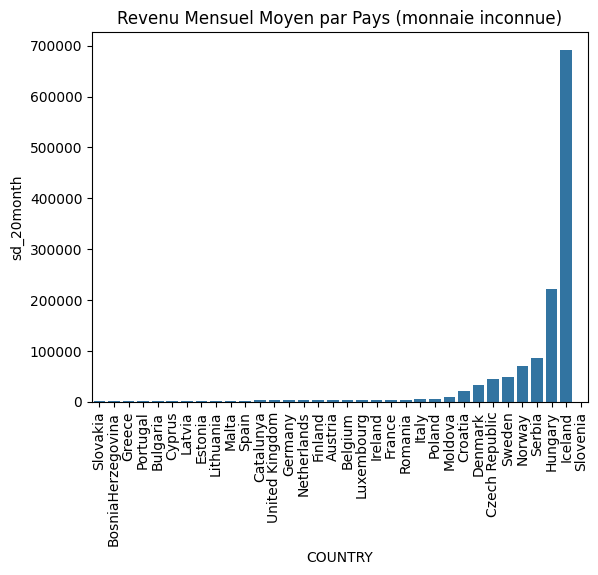

In [9]:
datalc= data.groupby('COUNTRY')['sd_20month'].mean().sort_values(ascending=True)
datalc = datalc.reset_index()
sns.barplot(x='COUNTRY', y='sd_20month', data=datalc)
plt.title("Revenu Mensuel Moyen par Pays (monnaie inconnue)")
plt.xticks(rotation=90)
plt.show()

La variable sd_20month du salaire mensuel est restée en monnaie local puisque les pays hors zone euro qui ont presque tous une monnaie plus faible que l'euro se retrouvent à avoir les salaires mensuels les plus élevés, alors que ce ne sont pas nécessairement ceux où le niveau de vie est le plus élevé. On notera que les valeurs manquent pour la Slovénie dû au fait que le questionnaire slovène n'a pas précisé si les répondants devaient donner leur salaire mensuel ou annuel, les sondeurs ont donc supprimer les données de salaire pour ce pays. 

Les entretients pour construire cette base de données ayant été menés en 2019 et 2020, nous choisissons de convertir tous les salaires en euros selon les valeurs publiées au journal officiel de l'Union Européenne pour le 2 janvier 2020. Cette date qui précède la crise Covid peut permettre d'éviter des erreurs d'interprétation des niveaux de vie, la crise Covid ayant fait significativement fluctuer les taux de change, faisant notamment s'apprécier l'euro par rapport à certaines monnaies début 2020 (couronne tchèque, islandaise, etc.).


In [10]:
# 1. Définir les taux de conversion (Unité Locale -> EUR) au 02/01/2020.
# Taux de change officiels du Journal officiel (BCE)
conversion_rates = {
    # Zone Euro (Taux fixe = 1)
    'Austria': 1.0, 'Belgium': 1.0, 'Cyprus': 1.0, 'Estonia': 1.0, 
    'Finland': 1.0, 'France': 1.0, 'Germany': 1.0, 'Greece': 1.0, 
    'Ireland': 1.0, 'Italy': 1.0, 'Latvia': 1.0, 'Lithuania': 1.0,
    'Luxembourg': 1.0, 'Malta': 1.0, 'Netherlands': 1.0, 'Portugal': 1.0, 
    'Slovakia': 1.0, 'Slovenia': 1.0, 'Spain': 1.0, 'Catalunya': 1.0,

    # Taux du Journal Officiel de l'UE
    'United Kingdom': 1 / 0.84828,   # GBP
    'Denmark': 1 / 7.4719,           # DKK
    'Sweden': 1 / 10.4728,          # SEK
    'Iceland': 1 / 136.90,          # ISK
    'Norway': 1 / 9.8408,           # NOK
    'Bulgaria': 1 / 1.9558,          # BGN
    'Czech Republic': 1 / 25.411,    # CZK
    'Hungary': 1 / 329.98,          # HUF
    'Poland': 1 / 4.2544,           # PLN
    'Romania': 1 / 4.7828,          # RON
    'Croatia': 1 / 7.4445,          # HRK
    
    # Autres pays (hors liste BCE -source = Google finance)
    'BosniaHerzegovina': 1 / 1.95583, # BAM 
    'Moldova': 1 / 19.33,            # MDL
    'Serbia': 1 / 117.85             # RSD
}


# 2.Créer une colonne de taux de conversion dans le DataFrame

data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(conversion_rates)

# 3.Appliquer la conversion à la variable 'sd_20month'
data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']


C:\Users\chris\AppData\Local\Temp\ipykernel_14700\3682300515.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(conversion_rates)
C:\Users\chris\AppData\Local\Temp\ipykernel_14700\3682300515.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']


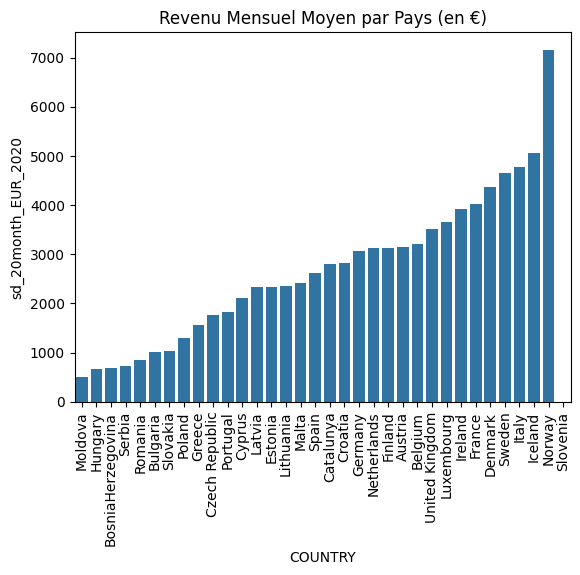

In [11]:
datawage= data.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().sort_values(ascending=True)

#diagramme du salaire mensuel moyen par pays 
datawage = datawage.reset_index()
sns.barplot(x='COUNTRY', y='sd_20month_EUR_2020', data=datawage)
plt.title("Revenu Mensuel Moyen par Pays (en €)")
plt.xticks(rotation=90)
plt.show()

On remarque que cette distribution des revenus n'est pas toujours cohérente avec la réalité des distributions moyennes de revenus entre les pays européens. Par exemple, le revenu moyen déclaré par les italiens interrogés est supérieur à celui des irlandais interrogés, ce qui n'est pas vrai dans la population totale. Cela témoigne soit d'un biais déclaratif plus élevé dans certains pays que d'autres, soit d'un biais de sélection du fait que les personnes interrogées dans certains pays (en Italie par exemple) font partie d'une partie plus favorisée économiquement de la population de leur pays que les individus interrogés dans d'autres pays (par exemple l'Irlande). Le cas échéant, cela signifie que les personnes interrogées ne sont pas équitablement répartis dans la distribution des revenus, dans certains pays du moins (ce que Kilian et Al. pointent du doigt dans leur papier "The socioeconomic profile of alcohol use in Europe: Findings
from a cross-sectional survey of 33 European countries" qui analyse Deepseas du point de vue européen).

*Premier traitement des valeurs manquantes*

In [12]:
data.apply(lambda x: x.isna().mean())

COUNTRY                 0.000000
SD_1                    0.000000
SD_2                    0.000000
SD_4                    0.000000
SD_6                    0.000000
SD_7                    0.212215
SD_8                    0.000000
SD_9                    0.000000
SD_10                   0.000000
sd_20month              0.242047
Demo_Empl               0.312583
social_class            0.000000
bsqf_alc                0.009480
f_1b                    0.000000
RSOD_5a                 0.456529
RSOD_5b                 0.456529
RSOD_5c                 0.456529
cbsqf_beer              0.000000
cbsqf_spir              0.000000
cbsqf_wine              0.000000
RSOD_5d                 0.456529
RSOD_2b                 0.268701
RSOD_7b                 0.502357
CH_1                    0.000000
WB_1                    0.000000
WB_2                    0.000000
WB_3                    0.000000
EXCHANGE_RATE_TO_EUR    0.000000
sd_20month_EUR_2020     0.242047
dtype: float64

<Axes: >

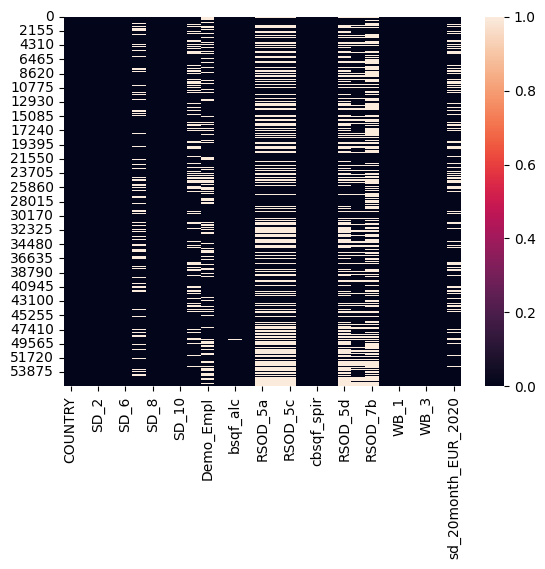

In [13]:
sns.heatmap(data.isna())

Les variables présentant des valeurs manquantes dans des proportions potentiellement problématiques sont:
- SD_7: le nombre de mineur dans le foyer de l'individu (21% de NA)
- SD_20month : le revenu du ménage par mois (24% de NA)
- Demo_Empl: si temps partiel, temps plein ou autre (31% de NA)
- Les RSOD_5(a à d): les lieux de consommation d'alcool (46% de NA)
- RSOD_2b : Fréquence 4/6+ verres en nombre de jours par an (46% de NA) ;
- RSOD_7b : Fréquence 8/12+ verres en nombre de jours par an (50% de NA)

Nous les traiterons une par une par la suite.

*Traitement de bsqf_alc la consommation d'alcool pur par an et par individu en cl*

In [14]:
missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean())
missing_by_country["bsqf_alc"]

C:\Users\chris\AppData\Local\Temp\ipykernel_14700\2176492060.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean())


COUNTRY
Austria              0.018094
Belgium              0.009309
BosniaHerzegovina    0.004667
Bulgaria             0.002329
Catalunya            0.011873
Croatia              0.002663
Cyprus               0.008667
Czech Republic       0.006662
Denmark              0.012018
Estonia              0.005563
Finland              0.000000
France               0.017564
Germany              0.023179
Greece               0.001314
Hungary              0.012942
Iceland              0.036667
Ireland              0.006662
Italy                0.003989
Latvia               0.003989
Lithuania            0.009229
Luxembourg           0.004648
Malta                0.029333
Moldova              0.001333
Netherlands          0.013298
Norway               0.014000
Poland               0.000641
Portugal             0.004660
Romania              0.005319
Serbia               0.007989
Slovakia             0.007973
Slovenia             0.014637
Spain                0.006647
Sweden               0.007371
Un

In [15]:
#Peu de valeurs manquantes dans la consommation d'alcool en cl d'alcool pur bsqf_alc (moins de 2% sauf Islande, Allemagne et Malte moins de 3.7%) 
# donc on peut supprimer les individus qui présentent des valeurs manquantes pour cette variable sans créer de biais de sélection.

data= data.dropna(subset=['bsqf_alc'])
sum(data['bsqf_alc'].isna())

0

*Les variables RSOD_5(a à d)*

In [16]:
variables = ['RSOD_5a', 'RSOD_5b', 'RSOD_5c', 'RSOD_5d']

#Pourcentage d'observations où TOUTES les variables RSOD_5(a à d) sont manquantes
pourcentage_observations_manquantes_communes = data[variables].isna().all(axis=1).mean()

print(f"Nombre d'observations où toutes les variables sont manquantes : {pourcentage_observations_manquantes_communes}")

Nombre d'observations où toutes les variables sont manquantes : 0.45266117549519674


Les valeurs manquantes des RSOD_5(a à d) sont les mêmes, donc quand on ne connaît pas la récurrence de consommation d'alcool dans un lieu, on ne la connaît pour aucun. Ces variables présentent un très grand pourcentage de valeurs manquantes (46%) et ne sont pas évoqués dans la littérature que nous avons étudié comme déterminant d'un profil de consommateur d'alcool, nous décidons de ne pas les compléter et d'étudier leur rôle seulement au travers de quelques statistiques descriptives par pays.

*Traitement de RSOD_2b et RSOD_7b*

Variables catégorielles, respectivement la fréquence de consommation d'alcool supérieure à 4/6 verres et supérieure 8/12 verres.

In [17]:
#regardons si, de façon cohérente, les valeurs manquantes de RSOD_2b sont incluses dans celles de RSOD_7b qui en a davantage

print(f"NA uniquement dans 2b: {(data['RSOD_2b'].isna() & data['RSOD_7b'].notna()).sum()}")
print(f"NA uniquement dans 7b: {(data['RSOD_2b'].notna() & data['RSOD_7b'].isna()).sum()}")

NA uniquement dans 2b: 0
NA uniquement dans 7b: 13000


Donc si des valeurs sont manquantes dans RSOD_2b elles le sont bien aussi dans RSOD_7b, donc les gens qui n'ont pas répondu à leur fréquence de consommation d'alcool de 4/6+ verres n'ont pas non plus répondu à celle de 8/12+ verres .

Les RSOD_2b/7b sont codées comme suit (d'après le code book):

Frequency of
drinking 4/6+ (resp. 8/12+ )
drinks
- 1 = Every day
- 2 = 5-6 days a week
- 3 = 3-4 days a week
- 4 = 1 - 2 days a week
- 5 = 2 - 3 days a month
- 6 = One day in a month
- 7 = 6 - 11 days a year
- 8 = 2 - 5 days a year
- 9 = a single day in the past 12 months
- 10 = I did not drink in the past 12 months



Comme RSOD_7b a 50% de valeurs manquantes, on décide de l'abandonner pour ne garder que RSOD_2b qui en a 27%. On retiendra que, même si RSOD_7b est inclus dans RSOD_2b, on perd tout de même un peu d'information sur les alcoolisations ponctuelles importantes.

In [18]:
#Problème: On a remarqué en ouvrant la base sur excel (ça n'est donc pas une erreur d'interprétation des séparateurs) qu'il y a à la fois des 0 et des NA pour ces variables
#Alors que ce sont des catégorielles sans catégories 0 D'APRES LE CODEBOOK
#Comptons le nombre de 0 et de valeurs manquantes pour RSOD_2b
print(f"nombre de d'individus ayant RSOD_2b = 0: {data.loc[data['RSOD_2b']==0,'RSOD_2b'].count()}",
f", nombre de valeurs manquantes pour RSOD_2b: {data['RSOD_2b'].isna().sum()}")


nombre de d'individus ayant RSOD_2b = 0: 5286 , nombre de valeurs manquantes pour RSOD_2b: 14650


In [19]:
# Le codebook pourrait-il se tromper ?
# Essayons de voir combien d'individus correspondent à chaque code catégoriel de 1 à 10 possible:
print(data['RSOD_2b'].value_counts(dropna=False).sort_index())

RSOD_2b
0.0     5286
1.0      939
2.0      963
3.0     2597
4.0     4244
5.0     5590
6.0     3055
7.0     4499
8.0     6383
9.0     7277
NaN    14650
Name: count, dtype: int64


Il n'y a pas d'observation codée 10, il est cohérent de penser que le code book contient une erreur et que c'est le code 0 qui correspond à "I did not drink in the past 12 months [4/6+ drinks]" et non pas le code 10. 
Pour le vérifier, on va essayer de voir si les individus codés 0 sont bien ceux codés 10 dans le code book et si les codes des autres catégories sont restés inchangés ou non. Pour cela, on utilise la variable de fréquence de consommation d'alcool f_1b qui n'est pas un excellent proxy de RSOD_2b la fréquence de consommation de plus de 4/6 verres mais qui est le meilleur que nous ayons.

Rappel:codage de f_1b

generic
frequency of
drinking
- 1 = Every day
- 2 = 5-6 days a week
- 3 = 3-4 days a week
- 4 = 1 - 2 days a week
- 5 = 2 - 3 days a month
- 6 = One day in a month
- 7 = 6 - 11 days a year
- 8 = 2 - 5 days a year
- 9 = a single day in the past 12 months
- 10 = I did not drink but I drank earlier
- 11 = I never drank in my life

In [20]:
#On regarde quelle est la distribution de la variable f_1b

#print(data['f_1b'].value_counts(dropna=False).sort_index())

In [21]:
print(f"Le nombre d'individus où RSOD_2b=0 et f_1b=10 ou 11 est : {data.loc[(data['RSOD_2b']==0) & ((data['f_1b'] == 10) |  (data['f_1b'] == 11)), 'RSOD_2b'].count()}",
f", Le nombre d'individus ou RSOD_2b=0 est {data['RSOD_2b'].value_counts(dropna=False)[0]}")

Le nombre d'individus où RSOD_2b=0 et f_1b=10 ou 11 est : 5286 , Le nombre d'individus ou RSOD_2b=0 est 5286


Les individus ayant n'ayant jamais consommé d'alcool dans les 12 derniers mois ou durant toute leur vie (catégorie 10 et 11 de f_1b) sont biens les mêmes qui ont RSOD_2b=0.
Le code 10 est bien devenu 0.

Pour vérifier la concordances des codes 1 à 9 avec les labels du codebook, on crée une table de contingence entre RSOD_2b et f_1b.

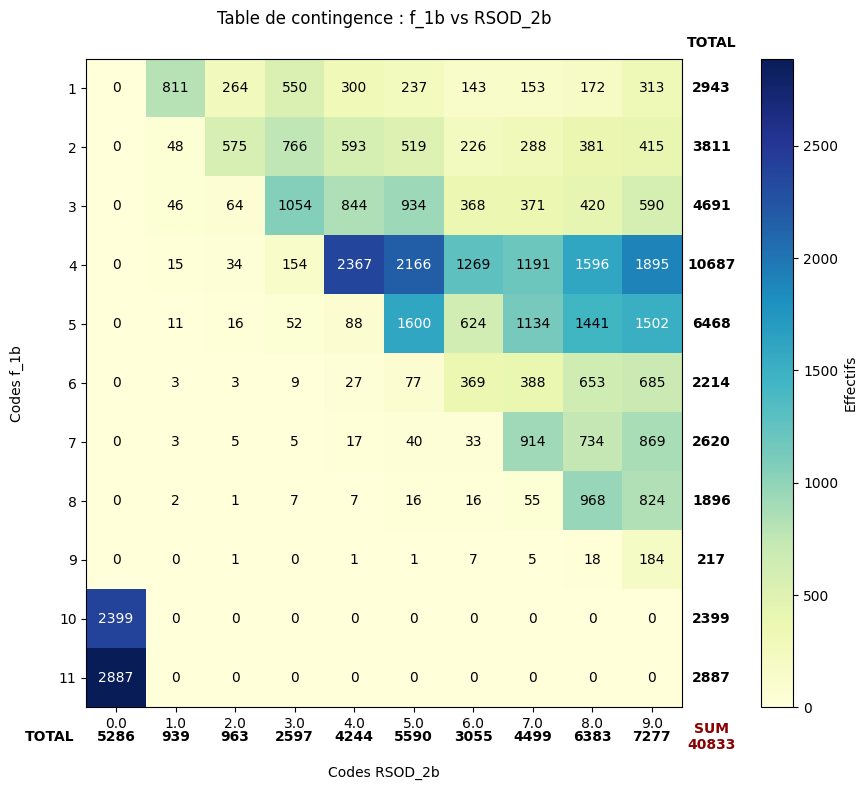

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# On est obligé de remplacer les RSOD_2b manquants par 0, ce qui est une limite à notre analyse
ct_f = pd.crosstab(data['f_1b'], data['RSOD_2b'], margins=True, margins_name="Total").fillna(0)
core, r_tot, c_tot, g_tot = ct_f.iloc[:-1, :-1], ct_f.iloc[:-1, -1], ct_f.iloc[-1, :-1], ct_f.iloc[-1, -1]

fig, ax = plt.subplots(figsize=(9, 8))
im = ax.imshow(core, cmap='YlGnBu', aspect='auto') #gradient de couleur
plt.colorbar(im, ax=ax, pad=0.1).set_label("Effectifs")

ax.set_xticks(np.arange(len(core.columns)))
ax.set_yticks(np.arange(len(core.index)))
ax.set_xticklabels(core.columns)
ax.set_yticklabels(core.index)

#Boucle pour afficher le nombre d'observations correspondant à la fois à la ligne i et la colonne j
thresh = core.values.max() / 2.
for i, j in np.ndindex(core.shape):
    val = core.iloc[i, j]
    ax.text(j, i, int(val), ha="center", va="center", color="white" if val > thresh else "black")

# Affichage des totaux
ax.text(len(core.columns), -0.7, "TOTAL", ha="center", fontweight='bold')
ax.text(-0.7, len(core.index), "TOTAL", ha="right", va="center", fontweight='bold')

for i, v in enumerate(r_tot):
    ax.text(len(core.columns), i, int(v), ha="center", va="center", fontweight='bold')
for j, v in enumerate(c_tot):
    ax.text(j, len(core.index), int(v), ha="center", va="center", fontweight='bold')

ax.text(len(core.columns), len(core.index), f"SUM\n{int(g_tot)}", ha="center", va="center", fontweight='black', color='darkred')

plt.title("Table de contingence : f_1b vs RSOD_2b", pad=25)
plt.xlabel("Codes RSOD_2b", labelpad=25)
plt.ylabel("Codes f_1b", labelpad=25)
plt.tight_layout()
plt.show()

Exemple d'interprétation: Tous les individus qui n'ont jamais consommé d'alcool dans leur vie ou durant les 12 derniers mois (f1_b=10 (2399 individus) ou 11(2887 individus)) n'ont jamais consommé plus de 4/6 verres d'alcool dans les 12 derniers mois. On valide de nouveau notre labelisation 0 = I did not drink in the past 12 month.

Autre façon d'interpréter :

La probabilité qu'un individu ait consommé plus de 4/6 verres d'alcool un seul jour par an sachant qu'il a consommé de l'alcool un seul jour par an est de 811/939 (case(1,1)/total de la colonne) = 0.86.

Puisque les codes 1 à 9 ont les mêmes labels pour les variables RSOD_2b et f_1b et que la diagonale de la table de contingence contient globalement dans les effectifs les plus élevés, en supposant une corrélation significative entre ces deux variables, on peut conclure que l'ordre  pas été décallé par rapport au codebook (hormis 10 évidemment). Si les codes avaient été décalés (par exemple si le 1 était devenu 2), nous verrions un décalage systématique de la diagonale, ce qui n'est pas le cas ici.

NB: On notera qu'on a remplacé les RSOD_2b manquants par 0 pour construire cette table ce qui est une légère limite à cette analyse.

Cela nous permet de confirmer assez sûrement l'hypothèse suivante:
La bonne distribution de RSOD_2b est:
Frequency of
drinking 4/6+ (resp. 8/12+ )
drinks
- 0 = I did not drink in the past 12 months
- 1 = Every day
- 2 = 5-6 days a week
- 3 = 3-4 days a week
- 4 = 1 - 2 days a week
- 5 = 2 - 3 days a month
- 6 = One day in a month
- 7 = 6 - 11 days a year
- 8 = 2 - 5 days a year
- 9 = a single day in the past 12 months


On peut par ailleurs utiliser cette table pour faire quelques commentaires sur la distribution statistique de RSOD_2b:


1. Dans nos deux échelles, plus le chiffre est petit, plus la fréquence est élevée (1 = tous les jours, 9 = 1 jour par an).

Or, on voit qu'il n'y a quasiment aucune observation dans la zone "sud-ouest" du tableau.

Ce qui est bon car cela signifie que personne n'a une fréquence de "forte consommation" (RSOD_2b) supérieure à sa fréquence de "consommation générale" (f_1b).Par exemple, personne n'est codé f_1b =4 (boit 1-2 fois/semaine) tout en étant RSOD_2b = 1 (boit 4/6+ verres tous les jours). C'est logiquement impossible, et la base respecte cela.

2. La distribution des "Binge Drinkers" (def: alcoolisation ponctuelle importante dans un temps très court, avec recherche d’ivresse)
Les points les plus denses pour les codes 1 à 9 se situent sur la diagonale ou légèrement à droite de celle-ci.

Exemple sur la ligne 4 (f_1b) : Le pic est au croisement avec la colonne 4 de RSOD_2b. Cela indique que les gens qui boivent 1 à 2 jours par semaine boivent souvent 4/6+ verres à chaque fois qu'ils consomment.

3. Les lignes 4 et 5 sont plus foncées:

Cela signifie que les consommateurs "intermédiaires" en terme de fréquence de consommation (entre 2 jours par semaine et deux jours par mois), consomment des quantités importantes d'alcool moins réguliérement que leur fréquence générale de consommation. Comme les effectifs sont relativement proches pour ces lignes, ces consommateurs intermédiaires ont des profils très hétérogènes dans leur attitude de "binge drinking", presque autant la pratiquent 2 à 3 fois par mois (2166 individus) que une fois par an (1895).

In [23]:
# On compte les NA
print(f"Nombre de NA dans RSOD_2b : {data['RSOD_2b'].isna().sum()}")

Nombre de NA dans RSOD_2b : 14650


Avant de traiter ces valeurs manquantes, nous regardons si les répondants diffèrent selon s'ils ont répondu ou non à la question sur leur consommation excessive d'alcool.

In [24]:
#création d'une variable valant 1 si RSOD_2b est manquante et 0 sinon
data['RSOD_2bisna'] = data['RSOD_2b'].isna().astype(int)

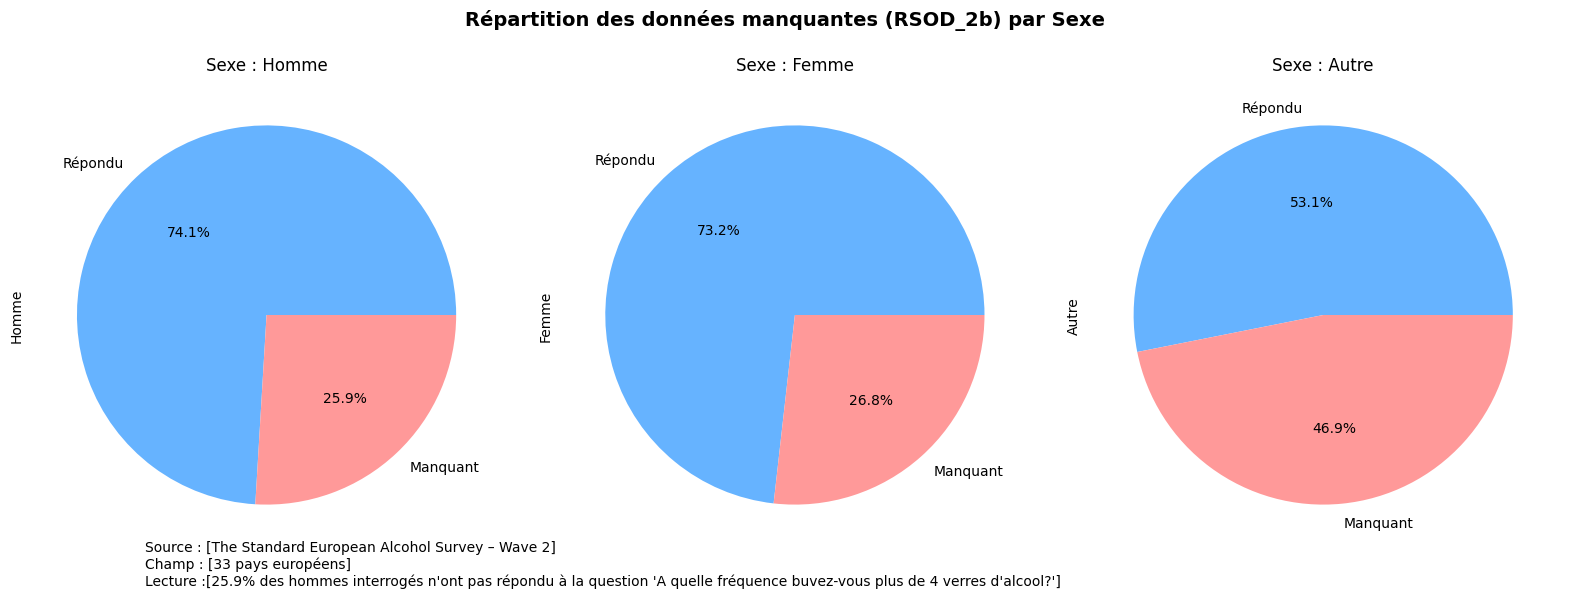

In [25]:
ct = pd.crosstab(data['RSOD_2bisna'], data['SD_1'])
ct.columns=["Homme","Femme","Autre"]
axes = ct.plot.pie(subplots=True, autopct='%1.1f%%', labels=['Répondu', 'Manquant'], 
                   legend=False, figsize=(16, 6), colors=['#66b3ff', '#ff9999'],
                   title=[f"Sexe : {c}" for c in ct.columns])


plt.figtext(0.1, 0.02, "Source : [The Standard European Alcohol Survey – Wave 2]\nChamp : [33 pays européens]\nLecture :[25.9% des hommes interrogés n'ont pas répondu à la question 'A quelle fréquence buvez-vous plus de 4 verres d'alcool?']", fontsize=10)
plt.suptitle("Répartition des données manquantes (RSOD_2b) par Sexe", fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

On remarque que les personnes ne se déclarant ni homme, ni femme répondent presque deux fois moins à la question sur leur consommation ponctuelle excessive d'alcool. Les interrogés se déclarant comme homme ou femmme répondent dans les mêmes proportion (~26%).
On peut l'interpréter de deux manières: 
- soit certaines personnes sont réticentes à dévoiler toute sorte d'information, que ce soit le genre ou la consommation excessive d'alcool;
- soit les personnes qui négligent le questionnaire négligent en particulier ces deux questions;
- soit les personnes ne s'identifiant à aucun genre sont plus réticent à dévoiler leur consommation d'alcool.
DANGEREUX REVOIR

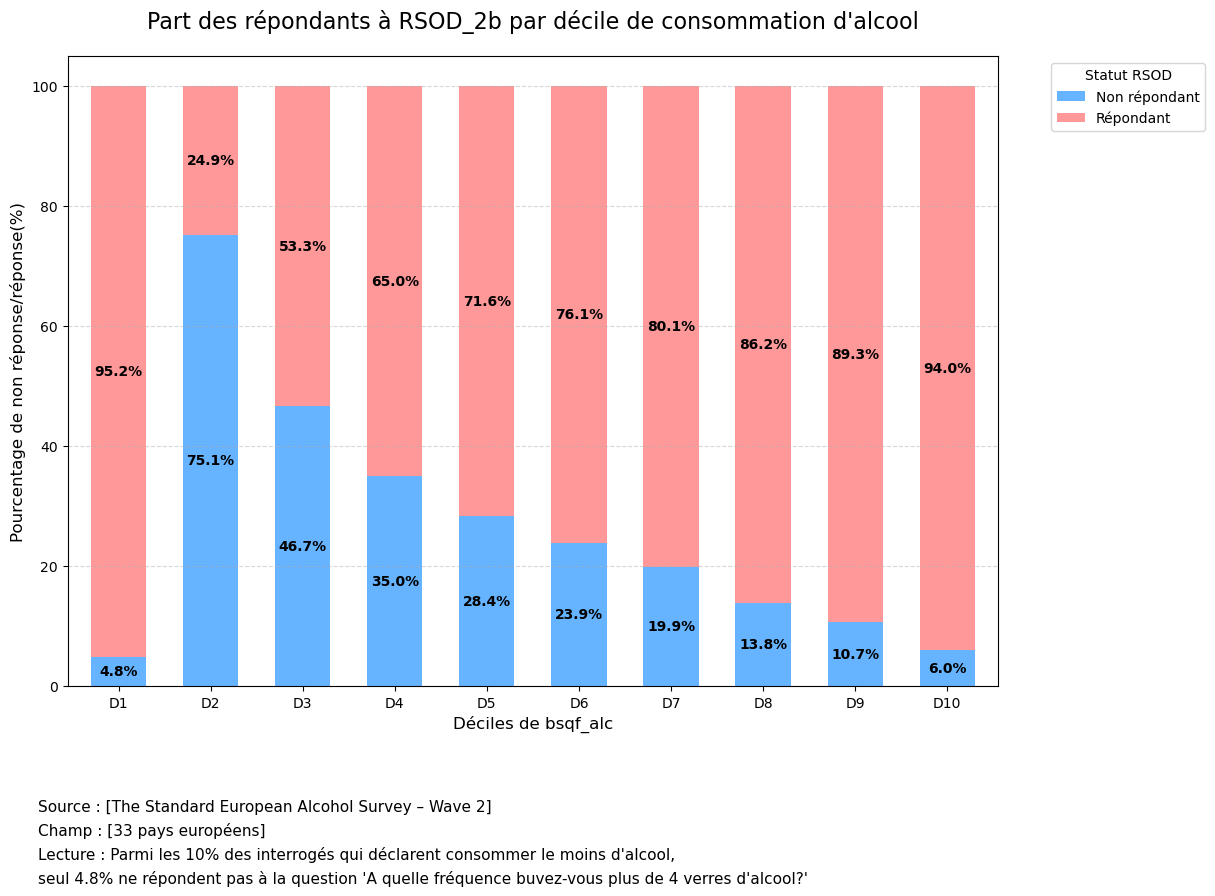

In [130]:
data['decile_alc'] = pd.qcut(data['bsqf_alc'], 10, labels=[f'D{i}' for i in range(1, 11)], duplicates='drop')
data['RSOD_statut'] = data['RSOD_2bisna'].map({0: 'Répondant', 1: 'Non répondant'})
tableau_stats = pd.crosstab(data['decile_alc'], data['RSOD_statut'], normalize='index') * 100


fig, ax = plt.subplots(figsize=(12, 10)) 
tableau_stats.plot(kind='bar', stacked=True, ax=ax, color=['#66b3ff', '#ff9999'], width=0.6)
plt.title("Part des répondants à RSOD_2b par décile de consommation d'alcool", fontsize=16, pad=20)
plt.xlabel('Déciles de bsqf_alc', fontsize=12)
plt.ylabel('Pourcentage de non réponse/réponse(%)', fontsize=12)
plt.legend(title='Statut RSOD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

#étiquettes de pourcentage 
for p in ax.patches:
    h = p.get_height()
    if h > 2:
        ax.text(p.get_x() + p.get_width()/2, p.get_y() + h/2, f'{h:.1f}%', 
                ha='center', va='center', fontsize=10, fontweight='bold')


plt.subplots_adjust(bottom=0.25) 

source_texte = (
    "Source : [The Standard European Alcohol Survey – Wave 2]\n"
    "Champ : [33 pays européens]\n"
    "Lecture : Parmi les 10% des interrogés qui déclarent consommer le moins d'alcool,\n"
    "seul 4.8% ne répondent pas à la question 'A quelle fréquence buvez-vous plus de 4 verres d'alcool?'"
)

fig.text(0.1, 0.05, source_texte, fontsize=11, ha='left', va='bottom', linespacing=1.6)

plt.show()

In [139]:
seuils = data['bsqf_alc'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
print(seuils)

0.1       1.375
0.2      18.910
0.3      53.000
0.4     117.900
0.5     216.750
0.6     370.510
0.7     612.000
0.8    1061.150
0.9    2206.948
Name: bsqf_alc, dtype: float64


INTERESSANT MAIS DIFFICILEMENT INTERPRETABLE

Relation en "U inversé" pour la non-réponse:
On observe que la part des "Non-répondants" (en bleu) n'est pas distribuée de manière uniforme :

Aux extrémités (D1 et D10) : Le taux de réponse est maximal. Les personnes qui consomment pas ou très peu d'alcool ou beaucoup répondent presque toutes à la question RSOD_2b.

On observe un pic de non-réponse, culminant à 75.1% pour le décile 2 et 46.7% pour le décile 3.

Proposition d'interprétation:
L'hypothèse explicative pourrait être que les gros consommateurs répondent plus facilement car ils identifient clairement ce comportement dans leur quotidien et sont donc plus enclins à déclarer une fréquence, même si elle est élevée. Et inversement pour les faibles consommateurs. 
Pour les très faibles consommateurs du 1er décile, ils consomment moins de 1.375 cl d'alcool par an, et savent donc qu'ils n'ont jamais consommé plus de 4 verres soit 40/7.89= 5 cl d'alcool. 

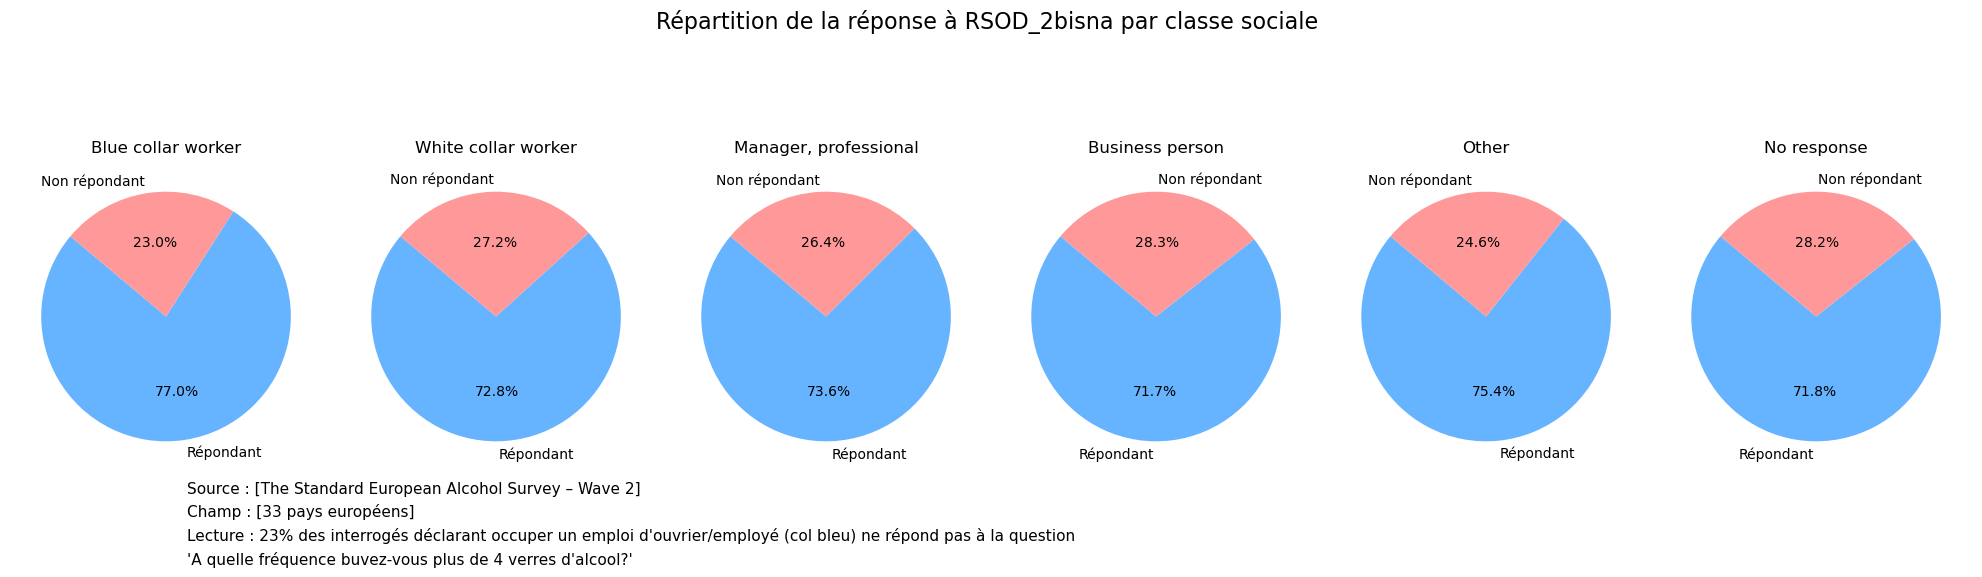

In [145]:
#A mettre en annexe
class_labels = {
    1.00: "Blue collar worker",
    2.00: "White collar worker",
    3.00: "Manager, professional",
    4.00: "Business person",
    5.00: "Other",
    9.00: "No response"
}
rsod_labels = {0: 'Répondant', 1: 'Non répondant'}


classes = sorted(data['social_class'].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(20, 6))

for i, s_class in enumerate(classes):
    subset = data[data['social_class'] == s_class]
    counts = subset['RSOD_2bisna'].value_counts().sort_index()
    
    axes[i].pie(
        counts, 
        labels=[rsod_labels.get(x, x) for x in counts.index],
        autopct='%1.1f%%', 
        startangle=140,
        colors=['#66b3ff', '#ff9999']
    )
    axes[i].set_title(class_labels.get(s_class, f"Classe {s_class}"))


source_texte = (
    "Source : [The Standard European Alcohol Survey – Wave 2]\n"
    "Champ : [33 pays européens]\n"
    "Lecture : 23% des interrogés déclarant occuper un emploi d'ouvrier/employé (col bleu) ne répond pas à la question\n"
    "'A quelle fréquence buvez-vous plus de 4 verres d'alcool?'"
)

fig.text(0.1, 0.05, source_texte, fontsize=11, ha='left', va='bottom', linespacing=1.6)


plt.suptitle("Répartition de la réponse à RSOD_2bisna par classe sociale", fontsize=16)
plt.tight_layout()
plt.show()

On observe pas de différence significative dans les taux de non réponse pour RSOD_2b entre les différentes classes sociales.
Une séquence de diagrammes circulaires l'illustre en annexe

In [151]:
missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean())
missing_by_country["RSOD_2b"].sort_values(ascending= True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_22980\852341470.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean())


COUNTRY
Bulgaria             0.111741
Poland               0.112251
Finland              0.114438
Ireland              0.136821
Estonia              0.151515
Czech Republic       0.153588
Latvia               0.160214
Greece               0.165789
Croatia              0.172897
Sweden               0.193069
Slovakia             0.198928
Norway               0.207573
Belgium              0.212081
Lithuania            0.220892
United Kingdom       0.230307
Serbia               0.231544
Austria              0.264232
Germany              0.266441
Romania              0.278075
Italy                0.279039
Malta                0.281593
Netherlands          0.285714
Denmark              0.288732
Hungary              0.289460
Spain                0.294404
Slovenia             0.320729
Portugal             0.328428
Catalunya            0.333111
Iceland              0.368858
France               0.414779
Moldova              0.461282
BosniaHerzegovina    0.463496
Luxembourg           0.464977
Cy

Le pourcentage de valeurs manquantes pour RSOD_2b varie aussi selon les pays allant de  0.11 pour la Bulgarie à 0.71. On totera que ces pays ont respectivement la plus forte et la plus faible consommation moyenne d'alcool en cl parmi les pays de la base. De manière générale, les pays qui consomment en moyenne le moins d'alcool ont bien aussi les plus hauts taux de non réponses et inversement.

Les personnes ayant RSOD_2b en valeur manquante ont donc bien un profil particulier, notamment en ce qui concerne leur consommation d'alcool. Les personnes qui consomment le moins d'alcool, répondent moins souvent à leur fréquence de consommation excessive. Ces valeurs manquantes engendrent donc un biais de sélection qu'il faudra prendre en compte dans nos interprétation. Ce qui est rassurrant pour notre analyse par pays, c'est que les pays qui consomment en moyenne le moins d'alcool ont bien aussi les plus hauts taux de non réponses et inversement. Si la baisse de la consommation de toute la population est proportionnelle à la hausse du nombre de valeur manquante, on peut se dire que le biais engendré sera environ le même peu importe les pays. A VERIFIER EMPIRIQUEMENT

*RSOD_2b - premiers traitement des valeurs manquantes*

Pour gérer les valeurs manquantes de RSOD_2b, on décide d'utiliser les variables de fréquence de consommation d'alcool par an (rf_1b) et de quantité consommée en gramme d'alcool pur (bsqf_alc).
Nous choisirons, comme les auteurs de la base le font dans leur conversions (cf. document "database guidelines" du github), de considérer qu'un verre d'alcool représente en moyenne 10 grammes d'alcool pur. 



Algorithme naïf :

0.  On prend toutes les valeurs manquantes de RSOD_2b
1.  diviser bsqf par masse volumique de l'alcool 0.789 kg/L
2.  diviser cela par rf_1b (recodé en quantitive en jour de consommation d'alcool par an)= on obtient la consommation moyenne en gramme d'alcool par jour où on a consommé de l'alcool sur l'année passée
3.  si celle-ci est inférieure à 40g (c'est à dire 4 verres), on met RSOD_2b = 0, sinon on met RSOD_2b= même valeur que fréquence générique rf1_b

On ne peut pas appliquer cet algorithme naïf qui réduirait la variance de consommation d'alcool des individus ayant une valeur manquante pour RSOD_2b à zéro.
Cependant, il y a deux cas de valeurs manquantes que l'on peut traiter facilement:
1) les individus qui ont consommé moins de 40g (soit 4 verres) d'alcool pur dans l'année et auxquels on peut attribuer RSOD_2b=0;
2) les individus qui ont consommé une seule fois par an plus de 40g d'alcool pur auxquels on peut attribuer RSOD_2b=9;

Pour le reste des valeurs manquantes sur cette variable, nous utiliserons la méthode d'imputation par "le plus proche voisin" après avoir sélectionner nos pays d'intérêt.

In [29]:
# 1
# On regarde le nombre d'individu qui consomme moins de 40g par an soit 4 verre d'alcool selon notre critère de conversion, 
# ceux là sont forcément dans la catégorie 0 de RSOD_2b

print(len(data.loc[data['RSOD_2b'].isna() & (data['bsqf_alc'] < 40/7.89)])) # On divise par la masse volumique de l'alcool pur en gramme/cl car bsqf_alc est en cl

#On remplace ces valeurs manquantes de RSOD_2b par 0 dans une nouvelle variable RSOD_2bcorrected
data['RSOD_2bcorrected'] =data['RSOD_2b'].copy()
data.loc[data['RSOD_2b'].isna() & (data['bsqf_alc'] < 40/7.89),'RSOD_2bcorrected'] = 0

1591


In [ ]:
#2
print(len(data.loc[data['RSOD_2bcorrected'].isna() & (data['bsqf_alc'] > 40/7.89) & (data['f_1b']==9)]))
data.loc[data['RSOD_2bcorrected'].isna() & (data['bsqf_alc'] > 40/7.89) & (data['f_1b']==9),'RSOD_2bcorrected'] = 9

146


*SD_7 et Demo_Empl*


Les valeurs manquantes des variables SD_7  (nombre d'enfant mineur dans le ménage) et Demo_Empl (Temps plein, temps partiel ou autre) seront traités par pays si des relations intéressantes sont trouvées sur les statistiques descriptives nationales concernant celles-ci. Elles ne sont pas évoquées comme majeures dans la détermination de la consommation d'alcool par la littérature. 

*sd_20month - salaire mensuel*

Il est important de traiter le cas de la variable salaire sd_20month, car les facteurs économiques jouent, selon la littérature, un rôle important dans la consommation d'alcool (les plus favorisés auraient notamment tendance à consommer plus régulièrement de l'alcool mais en moins grande quantité). Le salaire étant la seule variable quantitative indiquant la situation économique des individus que nous ayont, nous devons traiter le problème de valeur manquante sur cette variable.

In [33]:
missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean()) #on le remet car data a changé 
missing_by_country['sd_20month']
observation_count = data.groupby('COUNTRY').size()

# Ajouter le nombre d'observation par pays
missing_by_country['Observation_Count'] = observation_count

print(missing_by_country.loc[:, ["sd_20month", "Observation_Count"]])

                   sd_20month  Observation_Count
COUNTRY                                         
Austria              0.262257               3039
Belgium              0.251678               1490
BosniaHerzegovina    0.146015               1493
Bulgaria             0.208139               2998
Catalunya            0.295728               1498
Croatia              0.223632               1498
Cyprus               0.156691               1487
Czech Republic       0.168343               1491
Denmark              0.245198               1562
Estonia              0.524476               2145
Finland              0.166334               1503
France               0.128725               1678
Germany              0.153220               1475
Greece               0.230263               1520
Hungary              0.174987               1983
Iceland              0.094810               1445
Ireland              0.215962               1491
Italy                0.210280               1498
Latvia              

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_19132\1508566044.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_country = data.groupby('COUNTRY').apply(lambda x: x.isna().mean()) #on le remet car data a changé


Tous les pays ont un nombre conséquent d'observations (+de 1400). Nous obtiendrions donc des résultats statistiquements significatifs avec l'étude de chacun d'eux, ça n'est donc pas un critère pour sélectionner quel pays nous allons étudier.
Ils ont cependant des ratio de valeurs manquantes différents pour la variable salaire mensuelle sd_month, ce qui représentera un critère de sélection.

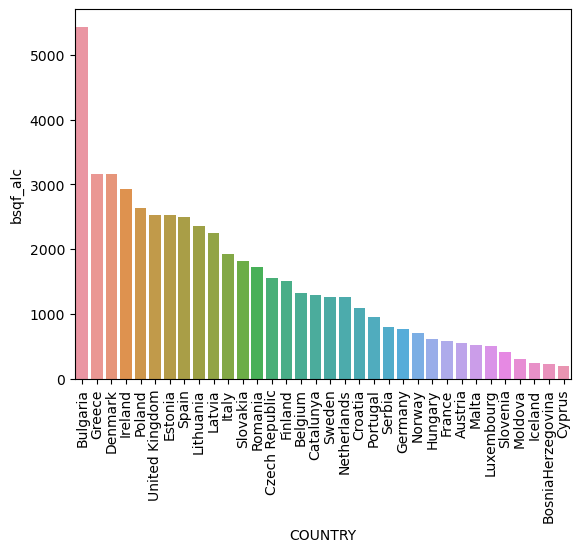

In [154]:
datalc= data.groupby('COUNTRY')['bsqf_alc'].mean().sort_values(ascending=False)

#diagramme de la moyenne de consommation d'alcool par pays (en cl d'alcool pur par an)
datalc = datalc.reset_index()
sns.barplot(x='COUNTRY', y='bsqf_alc', data=datalc)
plt.xticks(rotation=90)
plt.show()

In [155]:
data['COUNTRY'].unique()

array(['United Kingdom', 'Lithuania', 'Romania', 'Portugal', 'Germany',
       'Estonia', 'Belgium', 'Serbia', 'Hungary', 'Netherlands', 'Spain',
       'Denmark', 'Finland', 'Norway', 'Italy', 'Catalunya', 'Slovenia',
       'Austria', 'France', 'Slovakia', 'Greece', 'Sweden', 'Latvia',
       'Bulgaria', 'Croatia', 'Ireland', 'Poland', 'Luxembourg',
       'Czech Republic', 'Malta', 'Iceland', 'Moldova',
       'BosniaHerzegovina', 'Cyprus'], dtype=object)

In [161]:
# Calcul de la consommation moyenne par pays
stats_pays = data.groupby('COUNTRY')['bsqf_alc'].mean().reset_index()

# Chargement du fond de carte
world = gpd.read_file(r"C:\Users\Utilisateur\Documents\École\S1\python\110m_cultural\ne_110m_admin_0_countries.shp")

# Fusion des données
# On vérifie que les noms dans country_mapping correspondent à ceux de 'name' dans le fond de carte world
europe = world[world['CONTINENT'] == 'Europe']
map_data = europe.merge(stats_pays, left_on='NAME', right_on='COUNTRY', how='left')


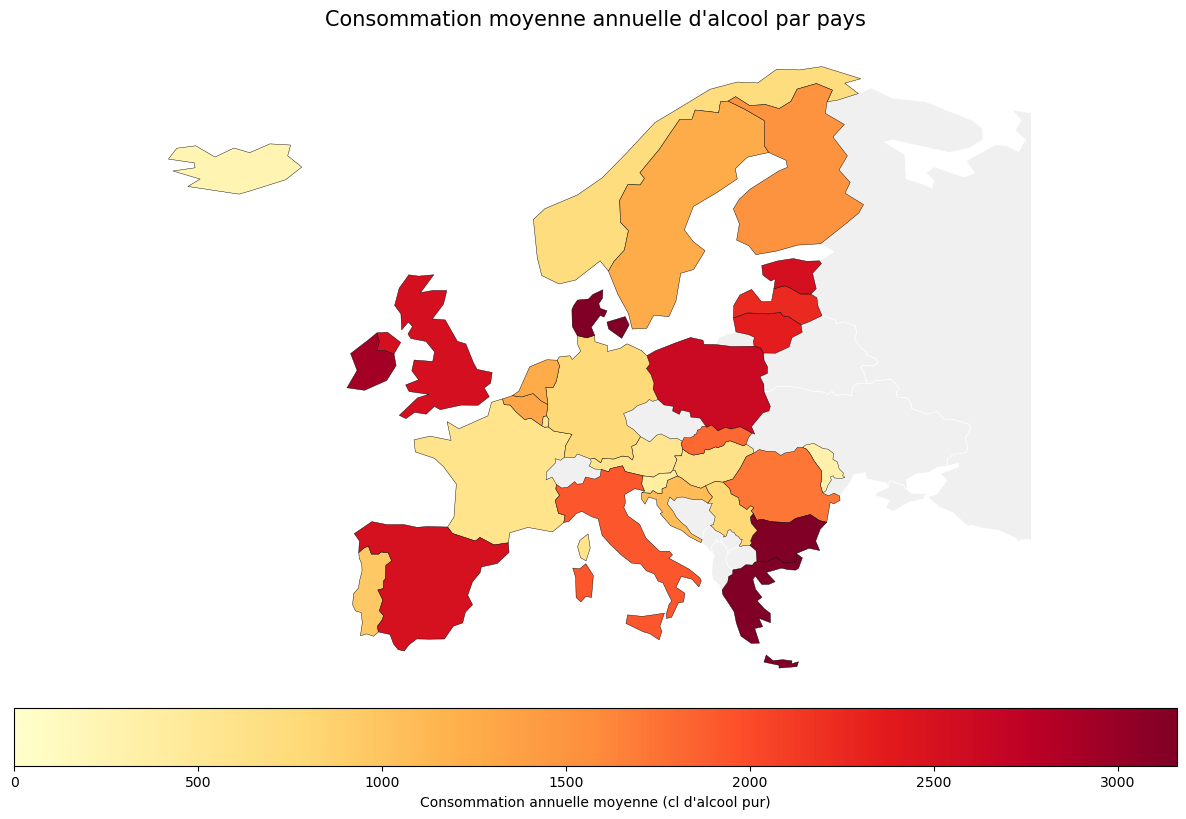

In [ ]:
import matplotlib.pyplot as plt

# 1. Préparation des statistiques
stats_pays = data.groupby('COUNTRY')['bsqf_alc'].mean().reset_index()

# 2. Fusion des données
map_data = europe.merge(stats_pays, left_on='NAME', right_on='COUNTRY', how='left')

# 3. Affichage de la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Fond de l'Europe en gris très clair
europe.plot(ax=ax, color="#f0f0f0", edgecolor='white', linewidth=0.5)

# Calcul manuel du max pour le gradient (ou fixez-le pour accentuer le contraste)
# Si vous voulez que les différences sautent aux yeux, vous pouvez réduire vmax
val_max = map_data['bsqf_alc'].quantile(0.95) # On sature à 95% pour que le rouge soit plus présent

# On trace les données
map_data.dropna(subset=['bsqf_alc']).plot(
    column='bsqf_alc', 
    ax=ax, 
    legend=True,
    # 'YlOrRd' offre un spectre plus large que 'OrRd' (du jaune au rouge foncé)
    cmap='YlOrRd', 
    vmin=0, 
    vmax=val_max, # Accentue le contraste sur les pays restants
    legend_kwds={
        'label': "Consommation annuelle moyenne (cl d'alcool pur)", 
        'orientation': "horizontal",
        'pad': 0.01
    },
    edgecolor='black',
    linewidth=0.3
)

# Ajustement vue Europe
ax.set_xlim(-25, 45)
ax.set_ylim(33, 72)
ax.set_title("Consommation moyenne annuelle d'alcool par pays", fontsize=15, pad=20)
ax.axis('off')

plt.show()

In [ ]:
data.groupby('COUNTRY')['bsqf_alc'].mean().sort_values(ascending=True)

COUNTRY
Cyprus                205.198107
BosniaHerzegovina     236.640506
Iceland               242.589647
Moldova               300.142423
Slovenia              406.714585
Luxembourg            510.276905
Malta                 514.330204
Austria               548.083531
France                585.695441
Hungary               609.769031
Norway                703.774055
Germany               773.758070
Serbia                794.984060
Portugal              950.801565
Croatia              1094.511644
Netherlands          1264.307564
Sweden               1265.684537
Catalunya            1300.424266
Belgium              1319.344460
Finland              1514.336666
Czech Republic       1549.297912
Romania              1724.810394
Slovakia             1813.477194
Italy                1924.703092
Latvia               2250.058178
Lithuania            2349.951613
Spain                2500.592609
Estonia              2526.571155
United Kingdom       2530.450822
Poland               2627.596199
Ir

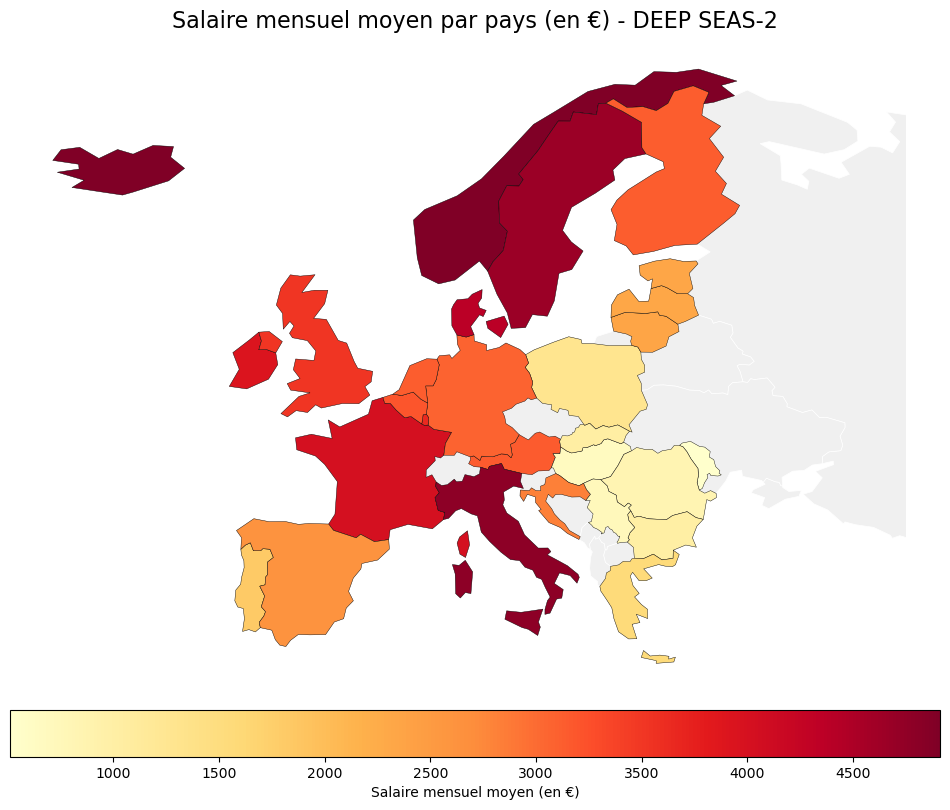

In [ ]:
import matplotlib.pyplot as plt

# 1. Calcul de la moyenne par pays
stats_pays = data.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().reset_index()

# 2. Fusion avec le fond de carte
# Assurez-vous que 'europe' est déjà défini comme dans votre code précédent
map_data = europe.merge(stats_pays, left_on='NAME', right_on='COUNTRY', how='left')

# 3. Affichage de la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Fond de carte neutre pour les pays sans données
europe.plot(ax=ax, color='#f0f0f0', edgecolor='white', linewidth=0.5)

# Pour booster le gradient, on définit vmax au 95ème percentile 
# Cela évite qu'un pays avec un salaire très élevé n'écrase les nuances des autres
vmax_salaire = map_data['sd_20month_EUR_2020'].quantile(0.95)
vmin_salaire = map_data['sd_20month_EUR_2020'].min()

# Affichage des données
map_data.dropna(subset=['sd_20month_EUR_2020']).plot(
    column='sd_20month_EUR_2020', 
    ax=ax, 
    legend=True,
    cmap='YlOrRd', # Palette Jaune -> Vert -> Bleu (très contrastée)
    vmin=vmin_salaire,
    vmax=vmax_salaire,
    legend_kwds={
        'label': "Salaire mensuel moyen (en €)", 
        'orientation': "horizontal",
        'pad': 0.02,
        'shrink': 0.8
    },
    edgecolor='black',
    linewidth=0.3
)

# Ajustements géographiques
ax.set_xlim(-25, 45)
ax.set_ylim(33, 72)
ax.set_title("Salaire mensuel moyen par pays (en €) - DEEP SEAS-2", fontsize=16, pad=20)
ax.axis('off')

plt.show()

Refaire une autre carte ou prendre sur internet pour critiquer distribution ici avec d'autres données.

In [ ]:
data_na = data.copy()
data_na['sd_20month_EUR_2020'] = data_na['sd_20month_EUR_2020'].isna()
data_na.head()

,COUNTRY,SD_1,SD_2,SD_4,SD_6,SD_7,SD_8,SD_9,SD_10,sd_20month,...,CH_1,WB_1,WB_2,WB_3,RSOD_2bcorrect,f1b_days_max,alc_per_drinking_day,RSOD_2bcorrected,EXCHANGE_RATE_TO_EUR,sd_20month_EUR_2020
0,United Kingdom,1,61,1,2,0.0,4,3,2,666.666667,...,1,3,2,1,NaN,12,10.837500,NaN,1.184834,False
1,United Kingdom,1,37,4,1,NaN,3,2,1,2083.333333,...,1,3,4,5,3.0,312,16.967500,3.0,1.184834,False
2,Lithuania,1,42,1,2,2.0,4,4,1,1500.000000,...,1,2,2,2,0.0,0,0.000000,0.0,1.000000,False
3,Lithuania,1,37,3,1,NaN,4,2,1,1500.000000,...,1,3,3,2,2.0,312,22.352244,2.0,1.000000,False
4,Lithuania,2,60,4,1,NaN,2,3,2,1500.000000,...,1,3,2,2,8.0,36,1.720833,8.0,1.000000,False


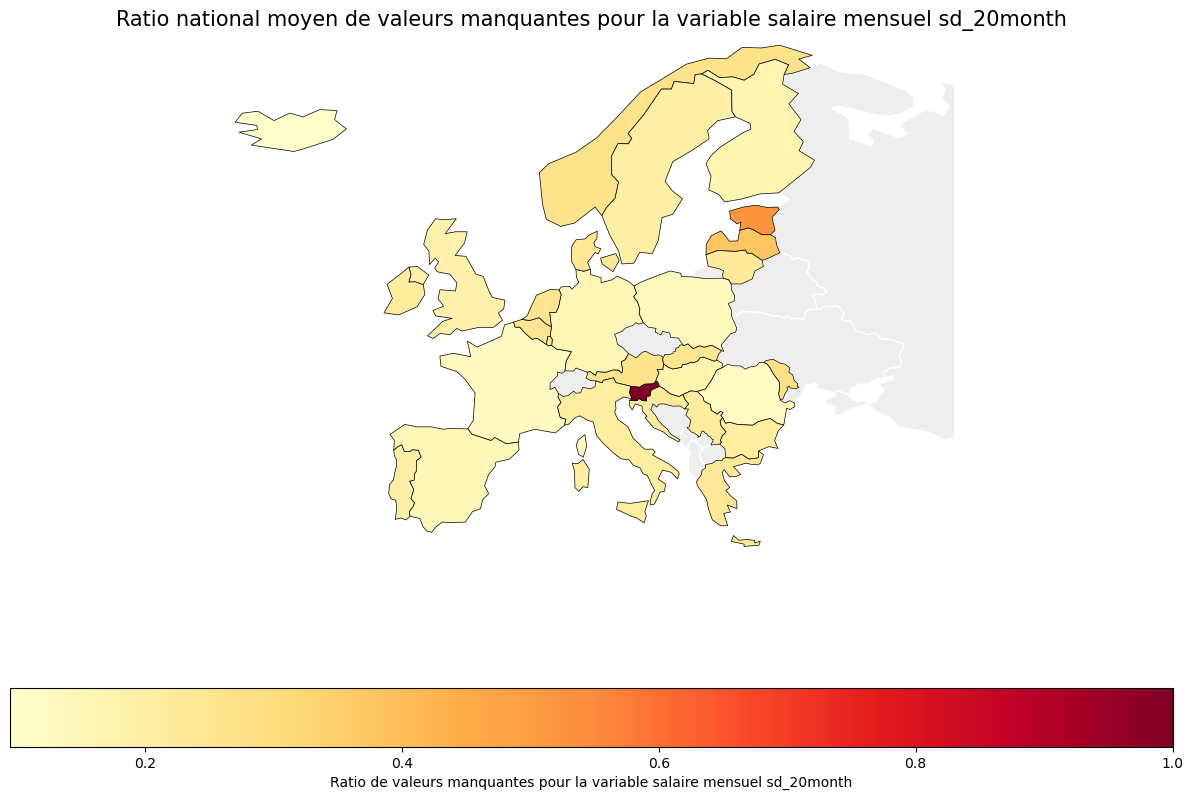

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Calcul de la consommation moyenne par pays
# On s'assure d'avoir les noms de pays dans le dataframe
#data['COUNTRY'] = data['COUNTRY'].map(country_mapping)
stats_pays = data_na.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().reset_index()

# 2. Chargement du fond de carte
world = gpd.read_file(r"C:\Users\Utilisateur\Documents\École\S1\python\110m_cultural\ne_110m_admin_0_countries.shp")

# 3. Fusion des données (Merge)
# Note : Vérifiez que les noms dans country_mapping correspondent à ceux de 'name' dans world
europe = world[world['CONTINENT'] == 'Europe']
map_data = europe.merge(stats_pays, left_on='NAME', right_on='COUNTRY', how='left')

# 4. Affichage de la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# On trace le fond de l'Europe en gris (pour les pays sans données)
europe.plot(ax=ax, color='#eeeeee', edgecolor='white')

# On trace les données de consommation
map_data.dropna(subset=['sd_20month_EUR_2020']).plot(
    column='sd_20month_EUR_2020', 
    ax=ax, 
    legend=True,
    legend_kwds={'label': "Ratio de valeurs manquantes pour la variable salaire mensuel sd_20month", 'orientation': "horizontal"},
    cmap='YlOrRd', # Dégradé Orange/Rouge
    edgecolor='black',
    linewidth=0.5
    
)

# Ajustement pour centrer sur l'Europe
ax.set_xlim(-25, 45)
ax.set_ylim(33, 72)
ax.set_title("Ratio national moyen de valeurs manquantes pour la variable salaire mensuel sd_20month", fontsize=15)
ax.axis('off')

plt.show()

In [ ]:
data_na.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().sort_values(ascending=True)

COUNTRY
Iceland              0.093333
Romania              0.122340
France               0.129977
Poland               0.134615
BosniaHerzegovina    0.146000
Spain                0.149849
Germany              0.153642
Cyprus               0.156000
Finland              0.166334
Czech Republic       0.168554
Hungary              0.176705
United Kingdom       0.181939
Malta                0.188667
Sweden               0.196560
Portugal             0.200399
Bulgaria             0.208652
Italy                0.211436
Serbia               0.214381
Ireland              0.215190
Croatia              0.223036
Lithuania            0.225445
Greece               0.230618
Denmark              0.247312
Slovakia             0.249834
Netherlands          0.253324
Belgium              0.253324
Luxembourg           0.254980
Austria              0.265267
Norway               0.268000
Moldova              0.280000
Catalunya            0.297493
Latvia               0.378324
Estonia              0.526657
Sl

In [ ]:
data_na_rsod= data.copy()
data_na_rsod['RSOD_2bcorrected']= data['RSOD_2bcorrected'].isna()
data_na_rsod.groupby('COUNTRY')['RSOD_2bcorrected'].mean().sort_values(ascending=True)

COUNTRY
Finland              0.092482
Bulgaria             0.095507
Poland               0.098718
Ireland              0.121919
Estonia              0.121929
Latvia               0.133644
Czech Republic       0.137242
Croatia              0.149134
Greece               0.156373
Norway               0.163333
Sweden               0.168305
Slovakia             0.180731
Serbia               0.186418
Lithuania            0.187871
Belgium              0.192154
United Kingdom       0.207171
Austria              0.239742
Romania              0.244681
Germany              0.247682
Hungary              0.258337
Denmark              0.262492
Netherlands          0.264628
Malta                0.266000
Italy                0.267287
Slovenia             0.284764
Spain                0.287009
Portugal             0.291611
Catalunya            0.314644
Iceland              0.324000
France               0.395785
Moldova              0.418000
Luxembourg           0.419655
BosniaHerzegovina    0.430667
Cy

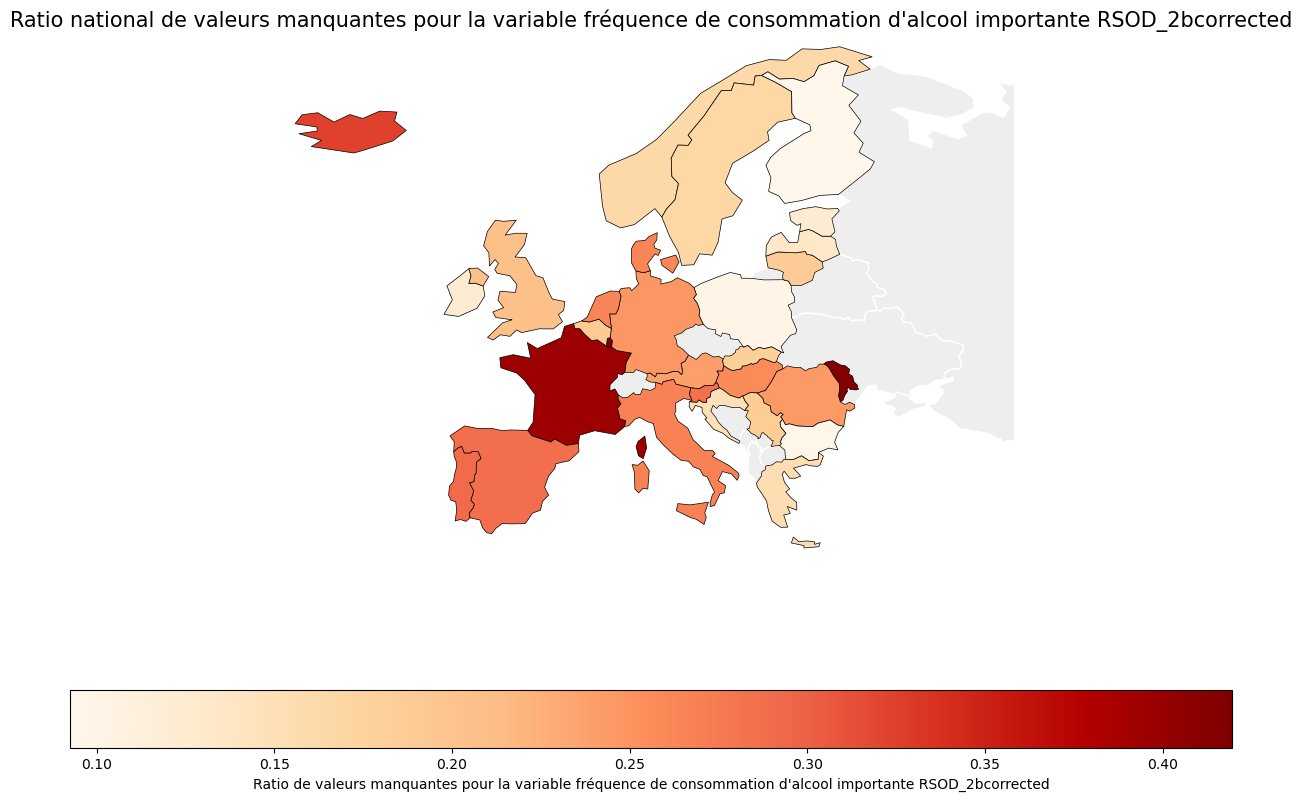

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Calcul de la consommation moyenne par pays
# On s'assure d'avoir les noms de pays dans le dataframe
#data['COUNTRY'] = data['COUNTRY'].map(country_mapping)
stats_pays = data_na_rsod.groupby('COUNTRY')['RSOD_2bcorrected'].mean().reset_index()

# 2. Chargement du fond de carte
world = gpd.read_file(r"C:\Users\Utilisateur\Documents\École\S1\python\110m_cultural\ne_110m_admin_0_countries.shp")

# 3. Fusion des données (Merge)
# Note : Vérifiez que les noms dans country_mapping correspondent à ceux de 'name' dans world
europe = world[world['CONTINENT'] == 'Europe']
map_data = europe.merge(stats_pays, left_on='NAME', right_on='COUNTRY', how='left')

# 4. Affichage de la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# On trace le fond de l'Europe en gris (pour les pays sans données)
europe.plot(ax=ax, color='#eeeeee', edgecolor='white')

# On trace les données de consommation
map_data.dropna(subset=['RSOD_2bcorrected']).plot(
    column='RSOD_2bcorrected', 
    ax=ax, 
    legend=True,
    legend_kwds={'label': "Ratio de valeurs manquantes pour la variable fréquence de consommation d'alcool importante RSOD_2bcorrected", 'orientation': "horizontal"},
    cmap='OrRd', # Dégradé Orange/Rouge
    edgecolor='black',
    linewidth=0.5
)

# Ajustement pour centrer sur l'Europe
ax.set_xlim(-25, 45)
ax.set_ylim(33, 72)
ax.set_title("Ratio national de valeurs manquantes pour la variable fréquence de consommation d'alcool importante RSOD_2bcorrected", fontsize=15)
ax.axis('off')

plt.show()

In [ ]:
quantitatives = ["SD_2", "SD_7", "sd_20month", "bsqf_alc", "rf_1b", "RSOD_2b", "RSOD_7b"]
quanti = data[quantitatives]
quali = data.drop(columns=quantitatives)
quanti

,SD_2,SD_7,sd_20month,bsqf_alc,rf_1b,RSOD_2b,RSOD_7b
0,61.0,0,666.666667,130.050,12,NaN,NaN
1,37.0,NaN,2083.333333,5293.860,286,3,3
2,42.0,2,1500.000000,0.000,0,0,0
3,37.0,NaN,1500.000000,6973.900,286,2,2
4,60.0,NaN,1500.000000,61.950,30,8,8
...,...,...,...,...,...,...,...
56009,41.0,0,3500.000000,359.400,78,4,4
56010,29.0,0,2500.000000,1239.600,286,8,8
56011,30.0,0,2000.000000,8.575,"3,5",NaN,NaN
56012,32.0,1,1000.000000,329.460,30,8,NaN


In [ ]:
for i in len(data):
    if data["rrsod_7b"]

In [ ]:
data[data["rrsod_2b"] == data["rrsod_7b"] ].describe()

,COUNTRY,SD_1,SD_2,SD_4,SD_6,SD_7,SD_8,SD_9,SD_10,Demo_Empl,social_class,RSOD_5a,RSOD_5b,RSOD_5c,RSOD_5d,CH_1,WB_1,WB_2,WB_3
count,30536.000000,30536.000000,30536.000000,30536.000000,30536.000000,23829.000000,30536.000000,30536.000000,30536.000000,20046.000000,30536.000000,10199.000000,10199.000000,10199.000000,10199.000000,30536.000000,30536.000000,30536.000000,30536.000000
mean,25.519747,1.518339,41.030980,2.043719,1.780358,0.712619,2.603746,3.068706,1.343529,1.232216,4.692658,3.000196,3.623689,3.877635,4.125895,1.750491,2.146319,2.187942,1.949044
std,10.017797,0.503003,12.950805,1.208163,0.414011,0.956631,1.243886,0.949552,0.474894,0.481436,3.271586,1.088098,0.970931,1.055867,1.057772,0.482067,0.877912,0.949216,0.829983
min,10.000000,1.000000,18.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,16.000000,1.000000,30.000000,1.000000,2.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,1.000000
50%,25.000000,2.000000,41.000000,1.000000,2.000000,0.000000,2.000000,3.000000,1.000000,1.000000,3.000000,3.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000
75%,34.000000,2.000000,52.000000,3.000000,2.000000,1.000000,3.000000,4.000000,2.000000,1.000000,9.000000,4.000000,4.000000,5.000000,5.000000,2.000000,3.000000,3.000000,2.000000
max,43.000000,3.000000,64.000000,5.000000,2.000000,12.000000,5.000000,5.000000,2.000000,3.000000,9.000000,5.000000,5.000000,5.000000,5.000000,3.000000,6.000000,6.000000,6.000000


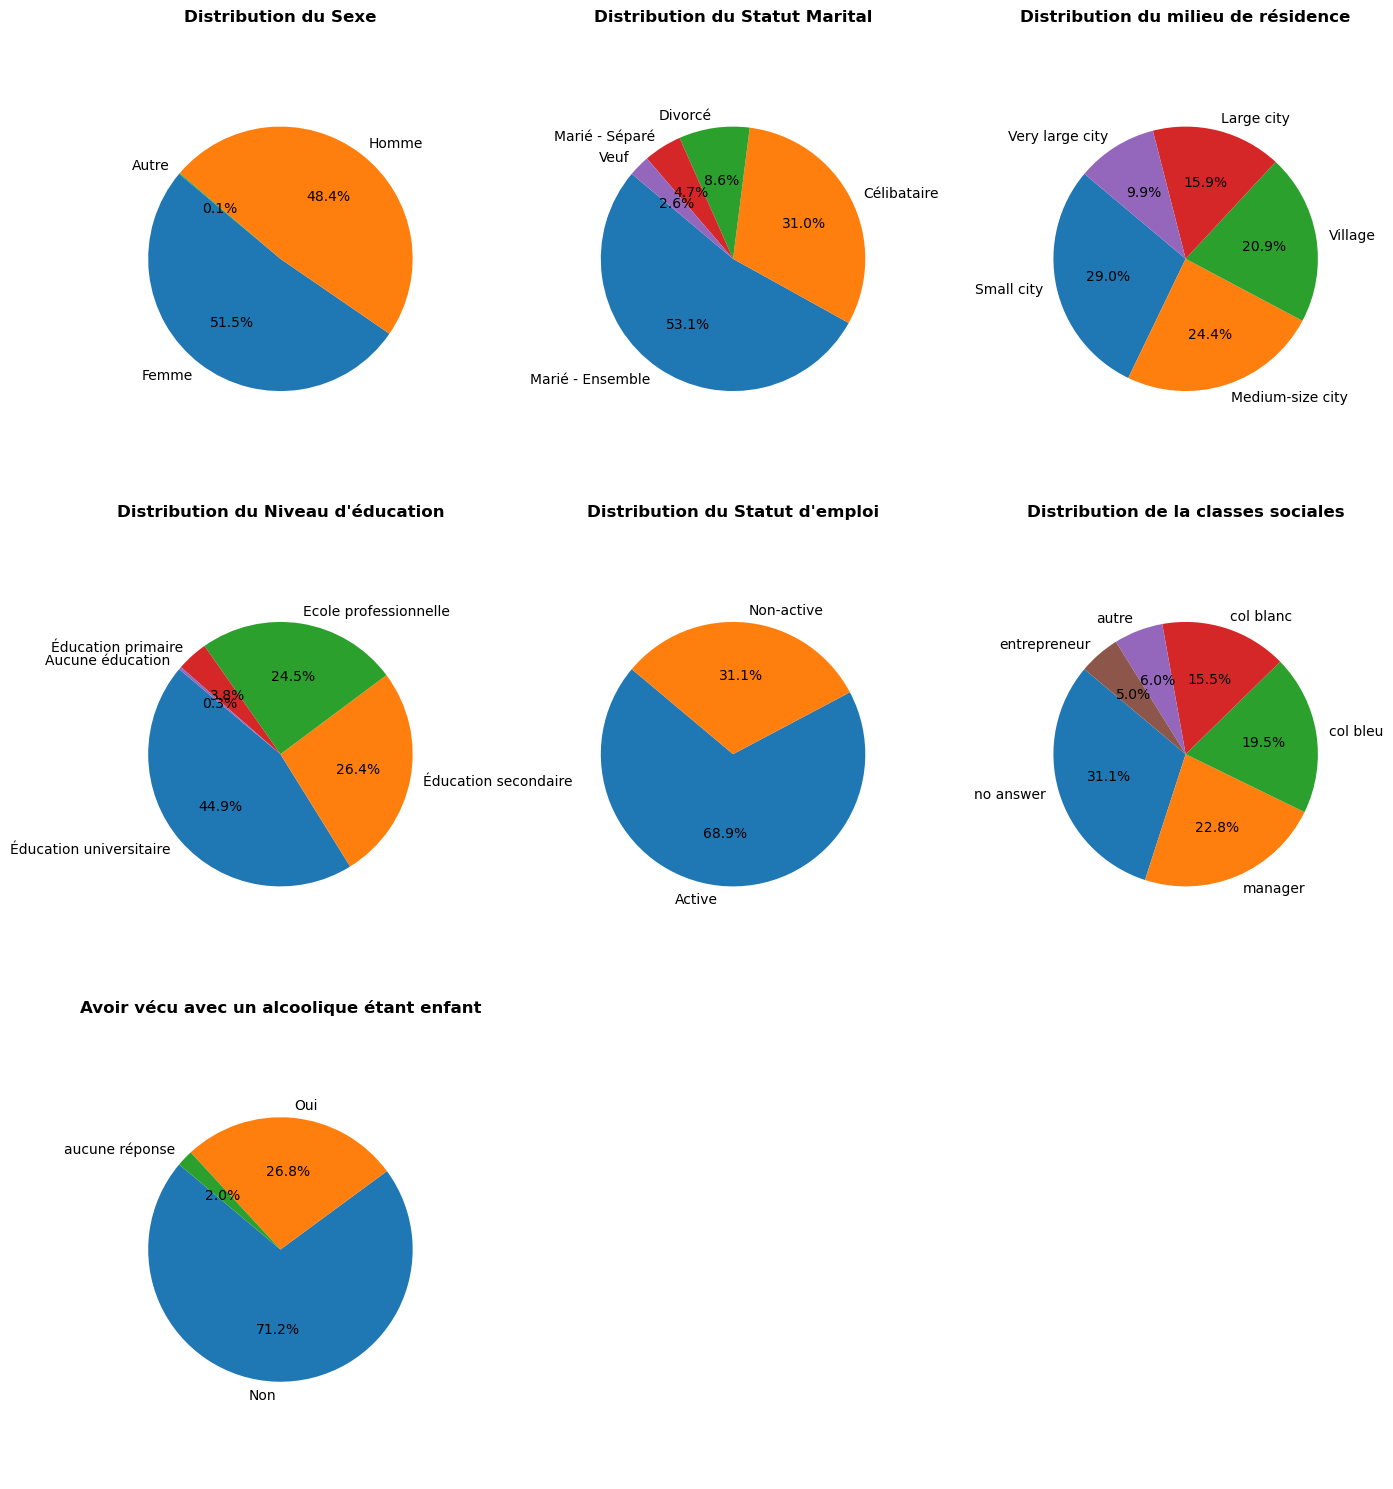

In [ ]:
# Diagramme circulaire de certaines variables qualitatives

qualitative = ["SD_1", "SD_4", "SD_8", "SD_9", "SD_10", "social_class", "CH_1"]
n_cols = 3
n_rows = (len(qualitative) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()

# Sexe (SD_1)
counts = data["SD_1"].value_counts()
etiquettes_SD1 = {1: 'Homme', 2: 'Femme', 3: 'Autre'}
labels_SD1 = [etiquettes_SD1.get(x, x) for x in counts.index]
axes[0].pie(counts, labels=labels_SD1, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Distribution du Sexe', fontsize=12, fontweight='bold')
axes[0].axis('equal')

# Statut marital (SD_4)
counts = data["SD_4"].value_counts()
etiquettes_SD4 = {
    1: 'Marié - Ensemble',
    2: 'Marié - Séparé',
    3: 'Célibataire',
    4: 'Divorcé',
    5: 'Veuf'
}
labels_SD4 = [etiquettes_SD4.get(x, x) for x in counts.index]
axes[1].pie(counts, labels=labels_SD4, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Distribution du Statut Marital', fontsize=12, fontweight='bold')
axes[1].axis('equal')

# Type de résidence (SD_8)
counts = data["SD_8"].value_counts()
etiquettes_SD8 = {
    1: 'Village',
    2: 'Small city',
    3: 'Medium-size city',
    4: 'Large city',
    5: 'Very large city'
}
labels_SD8 = [etiquettes_SD8.get(x, x) for x in counts.index]
axes[2].pie(counts, labels=labels_SD8, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Distribution du milieu de résidence', fontsize=12, fontweight='bold')
axes[2].axis('equal')

# Niveux d'éducation (SD_9)
counts = data["SD_9"].value_counts()
etiquettes_SD9 = {
    1: 'Éducation primaire',
    2: 'Éducation secondaire',
    3: 'Ecole professionnelle',
    4: 'Éducation universitaire',
    5: 'Aucune éducation'
}

labels_SD9 = [etiquettes_SD9.get(x, x) for x in counts.index]
axes[3].pie(counts, labels=labels_SD9, autopct='%1.1f%%', startangle=140)
axes[3].set_title('Distribution du Niveau d\'éducation', fontsize=12, fontweight='bold')
axes[3].axis('equal')

# statut d'emploi (SD_10)
counts = data["SD_10"].value_counts()
etiquettes_SD10 = {
    1: 'Active',
    2: 'Non-active'
}
labels_SD10 = [etiquettes_SD10.get(x, x) for x in counts.index]
axes[4].pie(counts, labels=labels_SD10, autopct='%1.1f%%', startangle=140)
axes[4].set_title('Distribution du Statut d\'emploi', fontsize=12, fontweight='bold')
axes[4].axis('equal')

# social_class
counts = data["social_class"].value_counts()
etiquettes_social_class = {    
    1: 'col bleu',
    2: 'col blanc',
    3: 'manager',
    4: 'entrepreneur',
    5: 'autre',
    9: 'no answer'
}
labels_social_class = [etiquettes_social_class.get(x, x) for x in counts.index]
axes[5].pie(counts, labels=labels_social_class, autopct='%1.1f%%', startangle=140)
axes[5].set_title('Distribution de la classes sociales', fontsize=12, fontweight='bold')
axes[5].axis('equal')

# avoir vecu avec un alcoolique (CH_1)
counts = data["CH_1"].value_counts()   
etiquettes_CH1 = {
    1: 'Oui',
    2: 'Non',
    3: 'aucune réponse'
}
labels_CH1 = [etiquettes_CH1.get(x, x) for x in counts.index]         
axes[6].pie(counts, labels=labels_CH1, autopct='%1.1f%%', startangle=140)
axes[6].set_title('Avoir vécu avec un alcoolique étant enfant', fontsize=12, fontweight='bold')
axes[6].axis('equal')



# Masquer les subplots inutilisés
for idx in range(len(qualitative), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

c:\Users\Utilisateur\Documents\Téléchargements\Anaconda\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


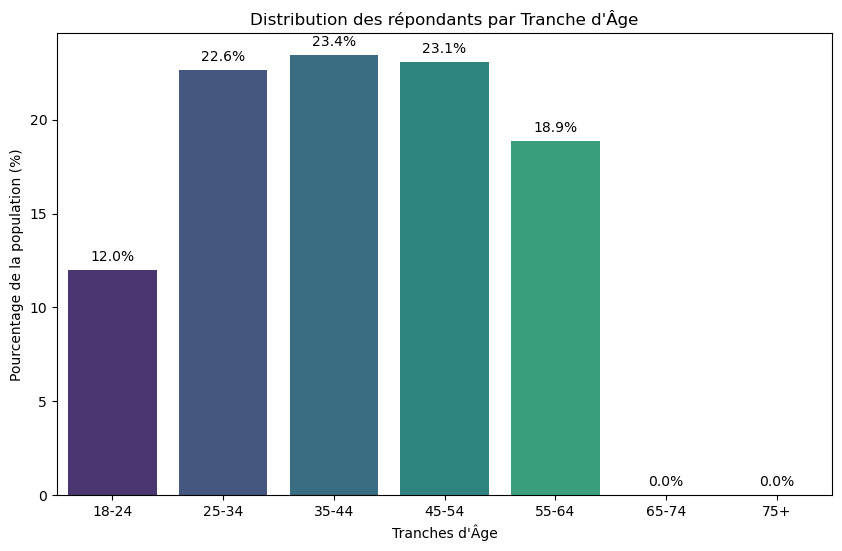


Distribution par Tranche d'Âge (en %):
Age_Tranche
18-24    12.0%
25-34    22.6%
35-44    23.4%
45-54    23.1%
55-64    18.9%
65-74     0.0%
75+       0.0%
Name: proportion, dtype: object


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Création de la variable de tranches d'âge ---
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']

data['Age_Tranche'] = pd.cut(
    data['SD_2'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# --- 2. Préparation des données pour le Barplot (Pourcentages) ---
age_distribution = data['Age_Tranche'].value_counts(normalize=True).mul(100).sort_index()

# --- 3. Création du Barplot ---
plt.figure(figsize=(10, 6))

sns.barplot(
    x=age_distribution.index,
    y=age_distribution.values,
    palette='viridis'
)

plt.title('Distribution des répondants par Tranche d\'Âge')
plt.xlabel('Tranches d\'Âge')
plt.ylabel('Pourcentage de la population (%)')

# Ajout des pourcentages au-dessus des barres
for index, value in enumerate(age_distribution.values):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center')

plt.show()

# 

print("\nDistribution par Tranche d'Âge (en %):")
print(age_distribution.round(1).astype(str) + '%')

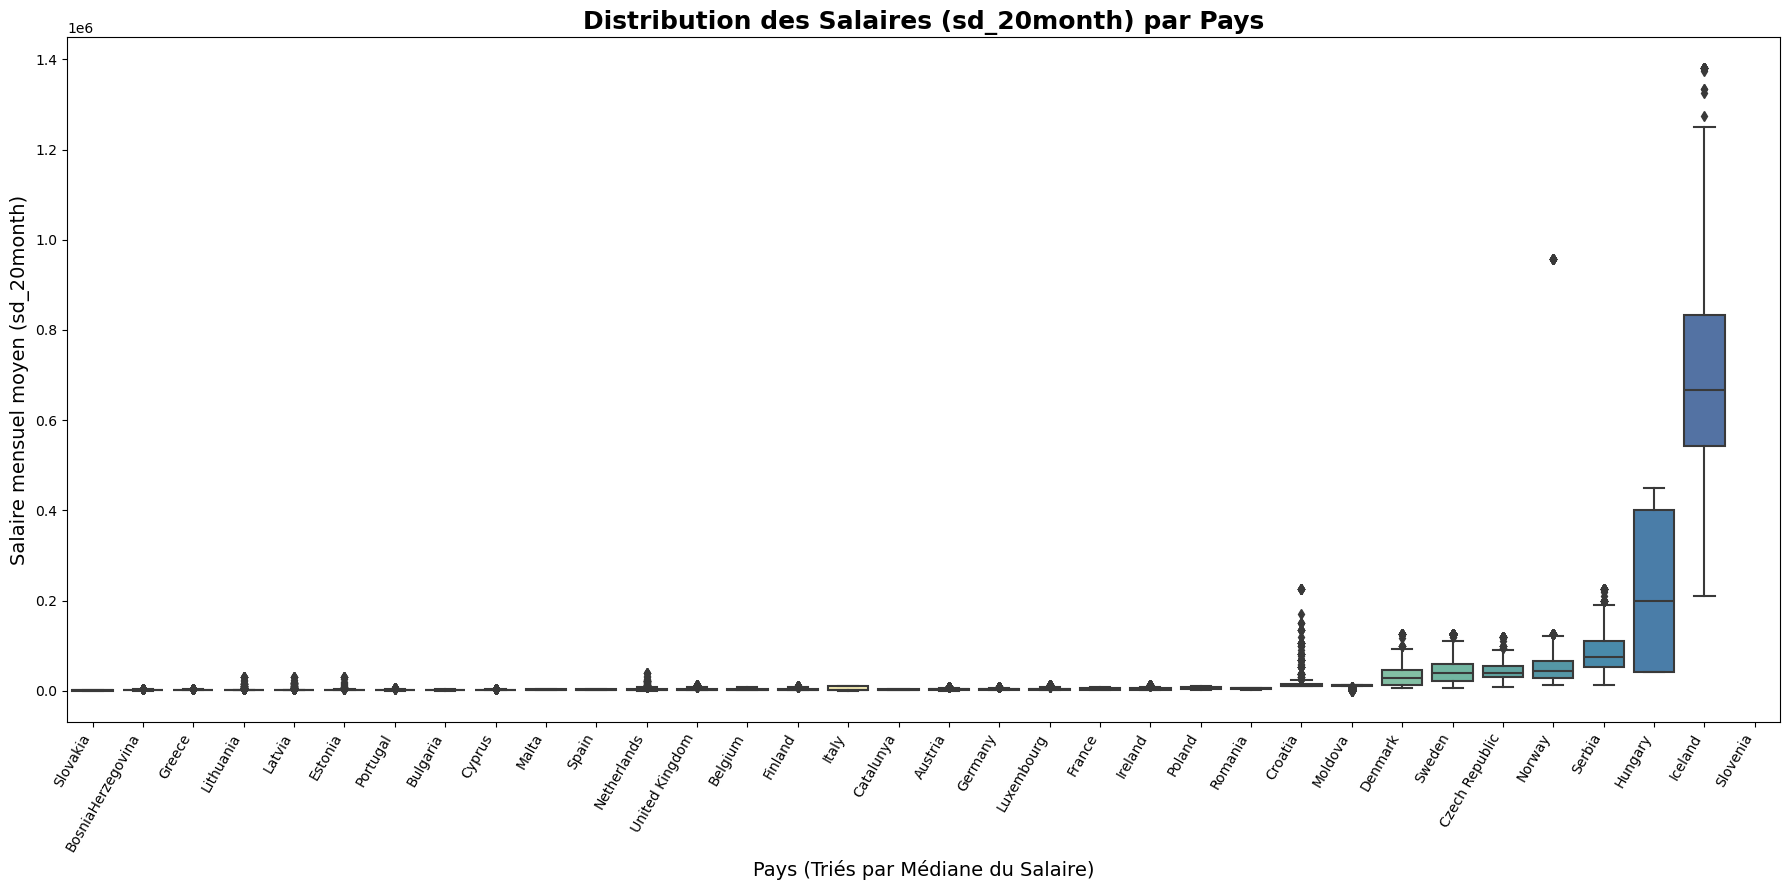

In [ ]:
median_order = data.groupby('COUNTRY')['sd_20month'].median().sort_values().index

plt.figure(figsize=(18, 9))

# Boxplot pour visualiser la distribution du salaire ('sd_20month') par pays
sns.boxplot(
    x='COUNTRY',     
    y='sd_20month', 
    data=data,
    order=median_order, 
    palette='Spectral'  
)

plt.title('Distribution des Salaires (sd_20month) par Pays', fontsize=18, weight='bold')
plt.xlabel('Pays (Triés par Médiane du Salaire)', fontsize=14)
plt.ylabel('Salaire mensuel moyen (sd_20month)', fontsize=14)

plt.xticks(rotation=60, ha='right', fontsize=10) 
plt.tight_layout()
plt.show()

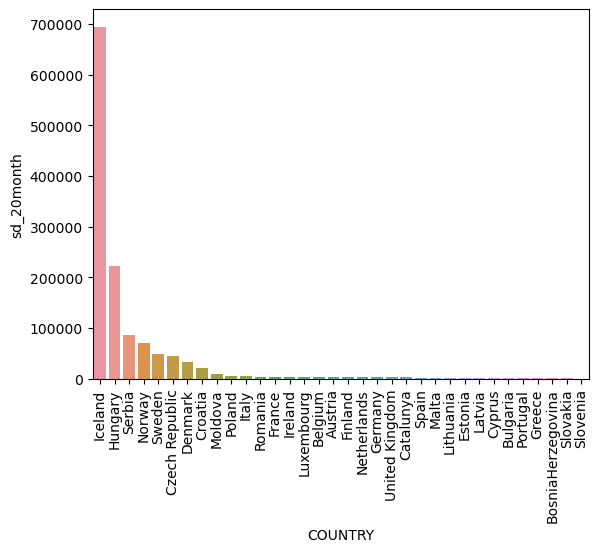

In [ ]:
datalc= data.groupby('COUNTRY')['sd_20month'].mean().sort_values(ascending=False)

#diagramme du salaire mensuel moyen par pays (en cl d'alcool pur par an)
datalc = datalc.reset_index()
sns.barplot(x='COUNTRY', y='sd_20month', data=datalc)
plt.xticks(rotation=90)
plt.show()
#IL Y A UN GROS PROBLEME !!!!!!!!! ON RETIRE LES VALEURS ABERRANTES FINALEMENT ?????? Non c'est en monnaie nationale attention serbie et islande problème d'après codebook

In [ ]:
# 1. Définir les taux de conversion (Unité Locale -> EUR) au 01/01/2020.
# Le taux est la valeur de 1 unité de la devise locale en EUR (1 / Taux (1 EUR = X Unités))
# Par exemple, pour PLN : 1 EUR = 4.256 PLN, donc 1 PLN = 1/4.256 EUR = 0.235 EUR
# Pour le GBP : 1 EUR = 0.844 GBP, donc 1 GBP = 1/0.844 EUR = 1.185 EUR

conversion_rates = {
    # Pays en EUR (Taux = 1)
    'Austria': 1.0, 'Belgium': 1.0, 'Cyprus': 1.0, 'Finland': 1.0, 'France': 1.0,
    'Germany': 1.0, 'Greece': 1.0, 'Ireland': 1.0, 'Italy': 1.0, 'Luxembourg': 1.0,
    'Malta': 1.0, 'Netherlands': 1.0, 'Portugal': 1.0, 'Slovakia': 1.0, 'Slovenia': 1.0,
    'Spain': 1.0, 'Catalunya': 1.0, 'Estonia': 1.0, 'Latvia': 1.0, 'Lithuania': 1.0,

    # Hors Zone Euro
    'BosniaHerzegovina': 1 / 1.956,  # BAM (Converti à un taux fixe)
    'Bulgaria': 1 / 1.956,           # BGN (Converti à un taux fixe)
    'Croatia': 1 / 7.430,            # HRK
    'Denmark': 1 / 7.472,            # DKK
    'Hungary': 1 / 330.50,           # HUF
    'Iceland': 1 / 138.83,           # ISK
    'Moldova': 1 / 19.33,            # MDL
    'Norway': 1 / 9.855,             # NOK
    'Poland': 1 / 4.256,             # PLN
    'Romania': 1 / 4.779,            # RON
    'Serbia': 1 / 117.85,            # RSD
    'Sweden': 1 / 10.467,            # SEK
    'Czech Republic': 1 / 25.40,     # CZK
    'United Kingdom': 1 / 0.844,     # GBP (1 GBP ≈ 1.185 EUR)
}

# 2. Créer une colonne de taux de conversion dans le DataFrame
# Assurez-vous que la colonne 'COUNTRY' est déjà mappée aux noms complets !
data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(conversion_rates)

# 3. Appliquer la conversion à la variable 'sd_20month'
# Si sd_20month est bien dans la devise locale :
data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']

# Afficher les premières lignes et la nouvelle colonne pour vérification
print(data[['COUNTRY', 'sd_20month', 'EXCHANGE_RATE_TO_EUR', 'sd_20month_EUR_2020']].head(10))

          COUNTRY   sd_20month  EXCHANGE_RATE_TO_EUR  sd_20month_EUR_2020
0  United Kingdom   666.666667              1.184834           789.889416
1  United Kingdom  2083.333333              1.184834          2468.404423
2       Lithuania  1500.000000              1.000000          1500.000000
3       Lithuania  1500.000000              1.000000          1500.000000
4       Lithuania  1500.000000              1.000000          1500.000000
5         Romania  5250.000000              0.209249          1098.556183
6         Romania  1200.000000              0.209249           251.098556
7       Lithuania  2500.000000              1.000000          2500.000000
8       Lithuania          NaN              1.000000                  NaN
9         Romania  3500.000000              0.209249           732.370789


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_24460\2774319098.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(conversion_rates)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_24460\2774319098.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']


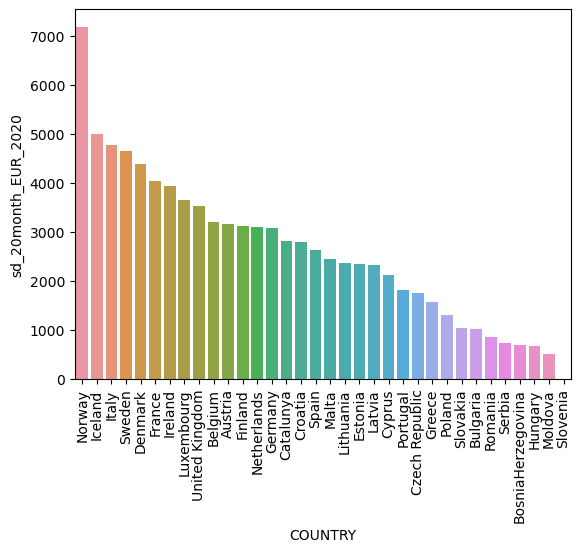

In [ ]:
datalc1= data.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().sort_values(ascending=False)

#diagramme du salaire mensuel moyen par pays (en cl d'alcool pur par an)
datalc1 = datalc1.reset_index()
sns.barplot(x='COUNTRY', y='sd_20month_EUR_2020', data=datalc1)
plt.xticks(rotation=90)
plt.show()

On remarque que cette distribution des revenus n'est pas toujours cohérente avec la réalité des distributions moyennes de revenus entre les pays européens. Par exemple, le revenu moyen déclaré par les italiens interrogés est supérieur à celui des irlandais interrogés, ce qui n'est pas vrai dans la population totale. Cela témoigne soit d'un biais déclaratif plus élevé dans certains pays que d'autres, soit du fait que les personnes interrogées dans certains pays (en Italie par exemple) font partie d'une partie plus favorisée économiquement de la population de leur pays que les individus interrogés dans d'autres pays (par exemple l'Irlande). Le cas échéant, cela signifie que les personnes interrogées ne sont pas équitablement répartis dans la distribution des revenus, dans certains pays du moins (ce que Kilian et Al. pointent du doigt dans leur papier "The socioeconomic profile of alcohol use in Europe: Findings
from a cross-sectional survey of 33 European countries" qui analyse Deepseas du point de vue Européen.)

In [ ]:


# Liste des variables quantitatives
quantitatives = ["SD_2", "SD_7", "sd_20month", "bsqf_alc", "rf_1b", "RSOD_2b", "RSOD_7b"]

data_subset = data[quantitatives].dropna()
correlation_matrix = data_subset.corr(method='pearson')

# 2. Visualisation (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Afficher les coefficients
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    linecolor='black'
)
plt.title('Matrice de Corrélation SEAS-2')
plt.show()

ValueError: could not convert string to float: '8,5'

In [ ]:
#statistiques descriptives de toutes les variables quantitatives
tab = data.select_dtypes(include='float').describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
labels = {
    'SD_2': 'Age',
    'SD_7': 'Nombre d\'enfant dans le foyer',
    'sd_20month': 'Salaire mensuel',
    'bsqf_alc': 'Consommation alcool annuel',
    'rf_1b': 'Frequence consommation alcool',
    'RSOD_2b': 'Fréquence de grande consommation',
    'RSOD_7b': 'Variable RSOD_7b'
    # Ajoutez les autres variables selon vos besoins
}

# Ajouter la colonne label en première position
tab.insert(0, 'label', tab.index.map(labels))
styled_tab = tab.style \
    .format({col: '{:.2f}' for col in tab.columns if col != 'label'}) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '10px'), ('color', 'black')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#E7E6E6')]},
        {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#F2F2F2')]}
    ])

styled_tab

,label,count,mean,std,min,25%,50%,75%,max
SD_2,Age,56014.00,41.06,12.82,18.00,30.00,41.00,52.00,64.00
sd_20month,Salaire mensuel,42456.00,41727.56,143282.45,125.00,1500.04,3000.50,11250.00,1380000.00
bsqf_alc,Consommation alcool annuel,55483.00,1606.70,16055.35,0.00,33.67,216.75,797.47,1544380.00


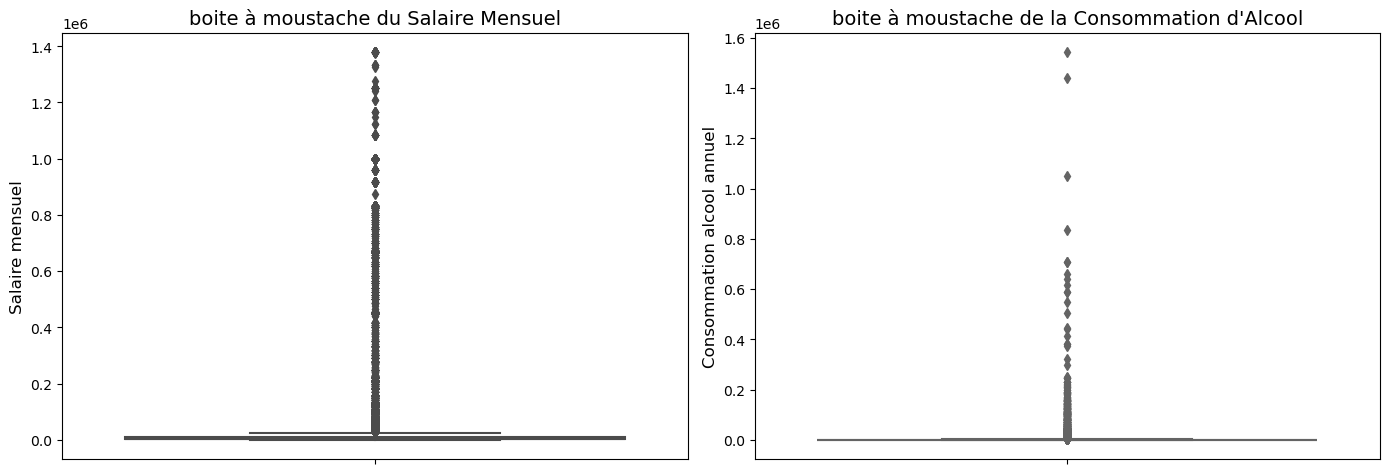

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot pour les salaires
sns.boxplot(y='sd_20month', data=data, ax=ax1, color='steelblue')
ax1.set_title('boite à moustache du Salaire Mensuel', fontsize=14)
ax1.set_ylabel('Salaire mensuel', fontsize=12)

# Boxplot pour la consommation d'alcool
sns.boxplot(y='bsqf_alc', data=data, ax=ax2, color='coral')
ax2.set_title('boite à moustache de la Consommation d\'Alcool', fontsize=14)
ax2.set_ylabel('Consommation alcool annuel', fontsize=12)

plt.tight_layout()
plt.show()

Ces graphiques confirment les suspicions de valeurs extrèmes dans ces variables.

In [ ]:
import pandas as pd
import numpy as np
#Pourcentage d'outliers par pays en par rapport aux quantiles PAR PAYS

# --- 1. Définition de la fonction de calcul du pourcentage d'outliers ---
def calculate_outlier_percentage(series):
    """
    Calcule le pourcentage de valeurs aberrantes (outliers) dans une série
    en utilisant la méthode de l'Écart InterQuartile (IQR).
    """
    # Exclure les valeurs manquantes avant le calcul
    series = series.dropna()

    # Si le pays n'a aucune donnée, retourner 0%
    if series.empty:
        return 0.0

    # 1. Calculer les quartiles et l'IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # 2. Définir les limites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 3. Compter les valeurs aberrantes
    outliers_count = series[(series < lower_bound) | (series > upper_bound)].count()

    # 4. Calculer le pourcentage
    total_count = series.count()
    outlier_percentage = (outliers_count / total_count) * 100

    return outlier_percentage

# --- 2. Application de la fonction par pays ---
# On utilise groupby() sur 'COUNTRY' et apply() la fonction sur 'bsqf_alc'.

outlier_percentage_by_country = (
    data
    .groupby('COUNTRY')['bsqf_alc']
    .apply(calculate_outlier_percentage)
    .sort_values(ascending=False)
)

# --- 3. Affichage des résultats ---

print("="*70)
print("Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Méthode IQR)")
print("="*70)

# Filtrer et formater pour l'affichage (seulement les pays avec des outliers)
outlier_df = outlier_percentage_by_country[outlier_percentage_by_country > 0].reset_index(name='Pourcentage_Outliers')

# Arrondir le pourcentage à deux décimales et ajouter le signe %
outlier_df['Pourcentage_Outliers'] = outlier_df['Pourcentage_Outliers'].round(2).astype(str) + '%'

print(outlier_df)
print("\n")

# Affichage des statistiques sommaires
print(f"\nPourcentage d'outliers moyen dans tous les pays: {outlier_percentage_by_country.mean():.2f}%")
print(f"Pays avec le pourcentage maximum: {outlier_percentage_by_country.idxmax()} ({outlier_percentage_by_country.max():.2f}%)")

Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Méthode IQR)
              COUNTRY Pourcentage_Outliers
0             Denmark               14.15%
1               Malta                13.6%
2   BosniaHerzegovina                13.4%
3             Estonia               12.77%
4           Catalunya               12.62%
5              Norway               12.31%
6             Iceland               12.25%
7              Latvia               12.15%
8             Belgium               11.81%
9               Spain               11.68%
10           Bulgaria               11.54%
11          Lithuania               11.44%
12            Moldova               11.42%
13             Sweden               11.32%
14           Slovenia               11.28%
15            Austria               11.25%
16             Cyprus               11.23%
17           Slovakia               11.19%
18            Ireland               10.93%
19             Greece               10.86%
20            G

In [ ]:


# --- 1. Calcul des bornes d'outliers globales sur l'ensemble de la base de données ---
series_global = data['bsqf_alc'].dropna()

Q1_global = series_global.quantile(0.25)
Q3_global = series_global.quantile(0.75)
IQR_global = Q3_global - Q1_global

lower_bound_global = Q1_global - 1.5 * IQR_global
upper_bound_global = Q3_global + 1.5 * IQR_global


# --- 2. Définition de la fonction de calcul du pourcentage d'outliers globaux par pays ---
def calculate_global_outlier_percentage(group, lower_bound, upper_bound):
    """
    Calcule le pourcentage d'outliers dans un groupe (pays) en utilisant
    les bornes globales fournies.
    """
    series = group.dropna()

    if series.empty:
        return 0.0

    # Compter les valeurs aberrantes par rapport aux bornes globales
    outliers_count = series[(series < lower_bound) | (series > upper_bound)].count()

    # Calculer le pourcentage par rapport au total des observations non manquantes du pays
    total_count = series.count()
    outlier_percentage = (outliers_count / total_count) * 100

    return outlier_percentage

# --- 3. Application de la fonction par pays ---
outlier_percentage_global = (
    data
    .groupby('COUNTRY')['bsqf_alc']
    .apply(calculate_global_outlier_percentage, lower_bound=lower_bound_global, upper_bound=upper_bound_global)
    .sort_values(ascending=False)
)

# --- 4. Affichage des résultats ---
print(f"Bornes d'outliers globales (sur l'ensemble des données): Q1={Q1_global:.2f}, Q3={Q3_global:.2f}")
print(f"Limite Inférieure = {lower_bound_global:.2f}, Limite Supérieure = {upper_bound_global:.2f}\n")

print("="*70)
print("Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Bornes Globales)")
print("="*70)

outlier_df = outlier_percentage_global.reset_index(name='Pourcentage_Outliers_Global')
outlier_df['Pourcentage_Outliers_Global'] = outlier_df['Pourcentage_Outliers_Global'].round(2).astype(str) + '%'
print(outlier_df)

Bornes d'outliers globales (sur l'ensemble des données): Q1=33.67, Q3=797.47
Limite Inférieure = -1112.04, Limite Supérieure = 1943.18

Pourcentage de valeurs aberrantes (Outliers) de 'bsqf_alc' par pays (Bornes Globales)
              COUNTRY Pourcentage_Outliers_Global
0            Bulgaria                      27.25%
1      United Kingdom                      19.96%
2               Spain                      19.65%
3              Poland                      19.31%
4             Ireland                      17.84%
5             Romania                      16.58%
6             Estonia                      15.38%
7             Belgium                      15.03%
8      Czech Republic                      15.02%
9             Denmark                      14.92%
10              Italy                      14.29%
11           Slovakia                      13.13%
12             Greece                       12.7%
13          Catalunya                      12.55%
14            Finland       

On remarque qu'il n'y a pas d'énormes différences dans les taux de valeurs aberrante de la consommation d'alcool quand ces outliers sont calculés chacuns par rapport au quartile de leur pays. Par contre, il y a de grosses différences de pourcentages de valeurs aberrantes quand on les calculs tous par rapport aux quantiles du dataset global (et les plus grands (resp. + petits) pourcentages d'outliers de ce point de vue sont en moyenne dans les pays qui déclarent consommer en moyenne plus d'alcool (resp. moins d'alcool) ). Ceci est rassurant, cela veut dire que soit il y a des pays extrêmes en termes de consommation d'alcool qui participent donc à créer beaucoup plus ces outliers que les autres, soit dans ces pays il y a des individus qui sur/sous évaluent leur consommation d'alcool plus que dans d'autres pays, ce qui dans les deux cas pourra participer à notre analyse, une fois faites la sélection des pays. Il ne semble donc pas y avoir de problème généralisé de valeurs abberantes non interprétable pour la variable de consommation d'alcool bsqf.

  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0     Dim 1            2.242705                 32.04                  32.04
1     Dim 2            1.124122                 16.06                  48.09


NameError: name 'components' is not defined

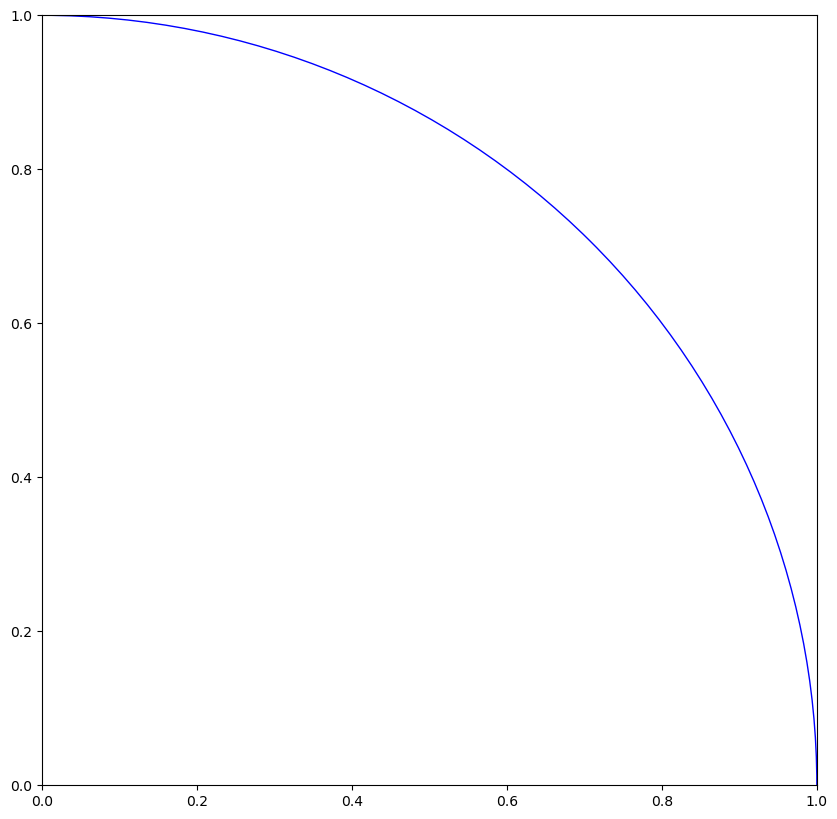

In [ ]:
# Standardisation des données quantitatives
scaler = StandardScaler()
quanti_scaled = scaler.fit_transform(quanti)

# ACP avec 2 composantes principales
pca = PCA(n_components=2)
pca.fit(quanti_scaled)

# Tableau des variances expliquées
eig = pd.DataFrame({
    "Dimension": [f"Dim {x+1}" for x in range(pca.n_components_)],  # Utilisez pca.n_components_ pour la longueur
    "Variance expliquée": pca.explained_variance_,
    "% variance expliquée": np.round(pca.explained_variance_ratio_ * 100, 2),
    "% cum. var. expliquée": np.round(np.cumsum(pca.explained_variance_ratio_) * 100, 2)
})

print(eig)

# Cercle des corrélations
plt.figure(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_patch(circle)

# Coordonnées des variables sur les axes principaux
loadings = components.T * np.sqrt(pca.explained_variance_)

# Tracé des flèches
for i, var in enumerate(quanti.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', head_width=0.05)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, var, color='red')

plt.xlabel(f"Composante Principale 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"Composante Principale 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("Cercle des corrélations (ACP)")
plt.grid()
plt.show()


In [26]:
from scripts import stats_desc as std

In [27]:
country = ['France', 'Poland', 'Iceland', 'Bulgaria']
data1 = data[data['COUNTRY'].isin(country)].copy()

# style général
sns.set_theme(style="whitegrid", context="talk")

In [28]:
vars_audit = [
    'SD_1', 'SD_2', 'SD_9', 'social_class',  
    'sd_20month_EUR_2020',                            
    'bsqf_alc', 'RSOD_2b',      
]
std.tableau_qualite_par_pays(data1, vars_audit)

 RAPPORT QUALITÉ DES DONNÉES PAR PAYS


N_Total                       % Manquant (NaN)         \
Pays                Bulgaria France Iceland Poland         Bulgaria France   
Variable                                                                     
RSOD_2b                 2998   1678    1445   1559             11.2   41.5   
SD_1                    2998   1678    1445   1559              0.0    0.0   
SD_2                    2998   1678    1445   1559              0.0    0.0   
SD_9                    2998   1678    1445   1559              0.0    0.0   
bsqf_alc                2998   1678    1445   1559              0.0    0.0   
sd_20month_EUR_2020     2998   1678    1445   1559             20.8   12.9   
social_class            2998   1678    1445   1559              0.0    0.0   

                                   % Refus (Refusal)                        
Pays                Iceland Poland          Bulgaria France Iceland Poland  
Variable                                                                    
RSOD_2b                36.9   11.2               0.0    0.0     0.0    0.0  
SD_1                    0.0    0.0               0.0    0.0     0.0    0.0  
SD_2                    0.0    0.0               0.0    0.0     0.0    0.0  
SD_9                    0.0    0.0               0.0    0.0     0.0    0.0  
bsqf_alc                0.0    0.0               0.0    0.0     0.0    0.0  
sd_20month_EUR_2020     9.5   13.4               0.0    0.0     0.0    0.0  
social_class            0.0    0.0               0.0    0.0     0.0    0.0

In [29]:
vars_audit= ['WB_1', 'WB_2', 'WB_3']
codes_refus = [6]
std.tableau_qualite_par_pays(data1, vars_audit, codes_refus)


 RAPPORT QUALITÉ DES DONNÉES PAR PAYS


N_Total                       % Manquant (NaN)                 \
Pays     Bulgaria France Iceland Poland         Bulgaria France Iceland   
Variable                                                                  
WB_1         2998   1678    1445   1559              0.0    0.0     0.0   
WB_2         2998   1678    1445   1559              0.0    0.0     0.0   
WB_3         2998   1678    1445   1559              0.0    0.0     0.0   

                % Refus (Refusal)                        
Pays     Poland          Bulgaria France Iceland Poland  
Variable                                                 
WB_1        0.0               0.3    0.6     0.1    0.3  
WB_2        0.0               0.2    0.5     0.1    0.2  
WB_3        0.0               0.3    0.6     0.0    0.1

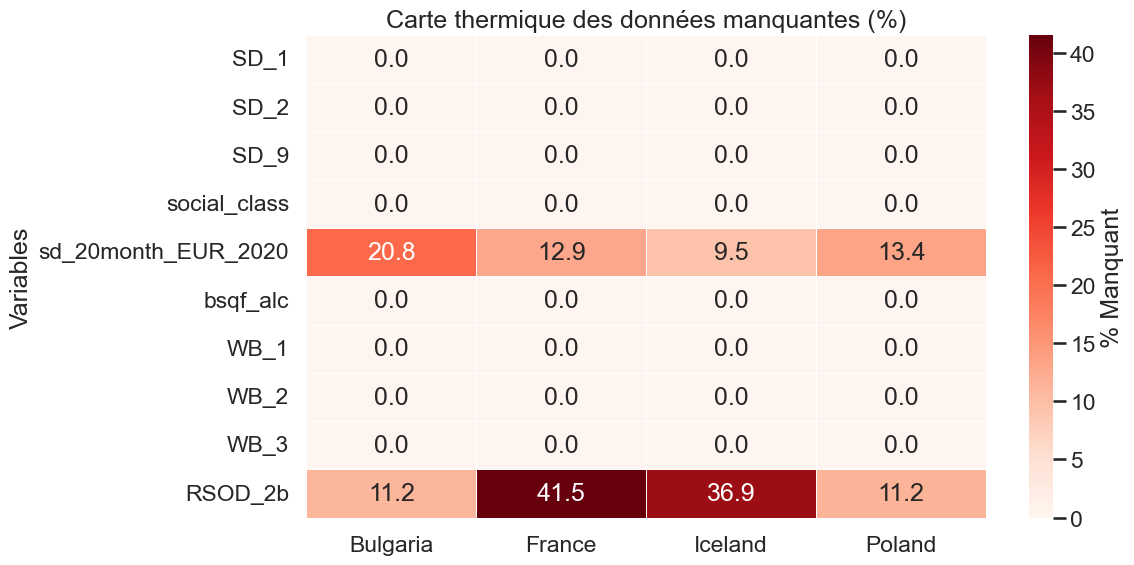

In [30]:
vars_audit = [
    'SD_1', 'SD_2', 'SD_9', 'social_class',  
    'sd_20month_EUR_2020',                            
    'bsqf_alc', 'WB_1', 'WB_2', 'WB_3', 'RSOD_2b',      
]
std.heatmap_manquants(data1, vars_audit)

Avant de lancer les analyses, un audit rapide de la base montre que les données sont globalement très saines. En effet, on peut voir que nous n'avons aucune valeur manquante sur les variables clés (âge, sexe, éducation, classe sociale) pour les quatre pays. Cela nous facilitera la comparaison des profils de consommateurs entre les pays.

Cependant,Comme souvent dans les enquêtes, le revenu mensuel (sd_20month_EUR_2020) comporte beaucoup de trous, surtout en Bulgarie (21 % de manquants) et en Pologne/France. Plutôt que de supprimer ces individus, nous procederons a une imputation par des regressions, de meme que pour les variables de binge drinking (RSOD_2b).



In [31]:
# Matching des variables
map_marital = {
    1: "Married/Living together",
    2: "Married/Living apart",
    3: "Never married",
    4: "Divorced",
    5: "Widowed"
}

map_residence = {
    1: "Village/Farm",
    2: "Small city (<50k)",
    3: "Medium city (50k-250k)",
    4: "Large city (250k-1M)",
    5: "Very large city (>1M)"
}

map_education = {
    1: "Primary",
    2: "Secondary",
    3: "Vocational",
    4: "University/Higher",
    5: "No schooling"
}

map_pro_status = {
    1: "Active",
    2: "Non-active"
}

map_social_class = {
    1: "Blue collar",
    2: "White collar",
    3: "Manager/Professional",
    4: "Business person",
    5: "Other",
    9: "No answer"
}


data1['Marital_Label'] = data1['SD_4'].map(map_marital)
data1['Residence_Label'] = data1['SD_8'].map(map_residence)
data1['Education_Label'] = data1['SD_9'].map(map_education)
data1['Activity_Label'] = data1['SD_10'].map(map_pro_status)
data1['Class_Label'] = data1['social_class'].map(map_social_class)


 ANALYSE : Statut Marital (Marital_Label)
>>> Tableau des Pourcentages (%) :
Marital_Label  Divorced  Married/Living apart  Married/Living together  \
COUNTRY                                                                  
Bulgaria            8.9                   5.0                     52.7   
France              8.5                   4.1                     51.9   
Iceland             6.2                   2.1                     58.0   
Poland              6.4                   7.3                     63.0   

Marital_Label  Never married  Widowed  
COUNTRY                                
Bulgaria                31.2      2.2  
France                  34.3      1.3  
Iceland                 32.6      1.2  
Poland                  22.1      1.2  

>>> Tableau des Effectifs (N) :
Marital_Label  Divorced  Married/Living apart  Married/Living together  \
COUNTRY                                                                  
Bulgaria            267                   149           

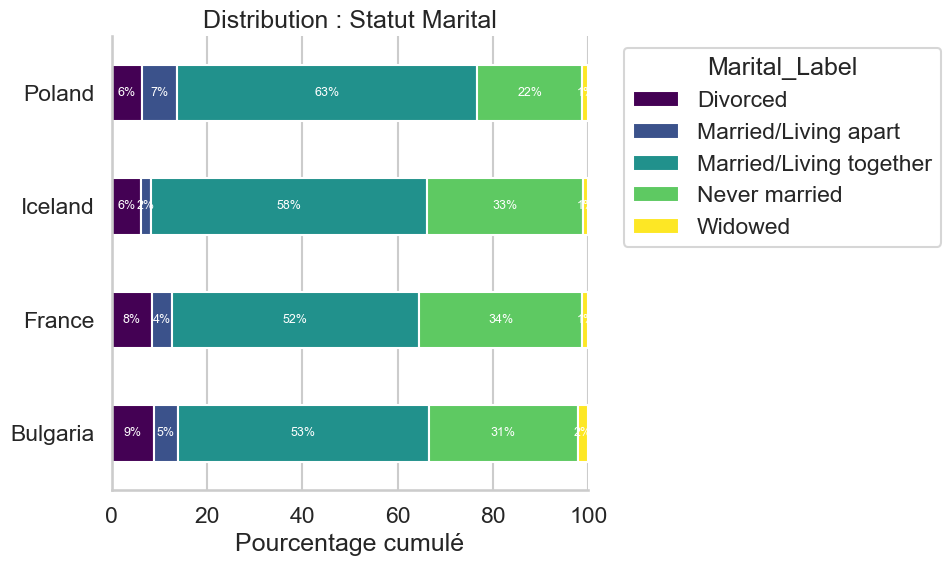


 ANALYSE : Type de Résidence (Residence_Label)
>>> Tableau des Pourcentages (%) :
Residence_Label  Large city (250k-1M)  Medium city (50k-250k)  \
COUNTRY                                                         
Bulgaria                         20.6                    21.8   
France                            9.2                    22.1   
Iceland                           9.6                    37.9   
Poland                           20.3                    26.6   

Residence_Label  Small city (<50k)  Very large city (>1M)  Village/Farm  
COUNTRY                                                                  
Bulgaria                      21.3                   29.7           6.5  
France                        35.0                    6.4          27.3  
Iceland                       42.5                    1.9           8.2  
Poland                        24.2                   10.1          18.8  

>>> Tableau des Effectifs (N) :
Residence_Label  Large city (250k-1M)  Medium cit

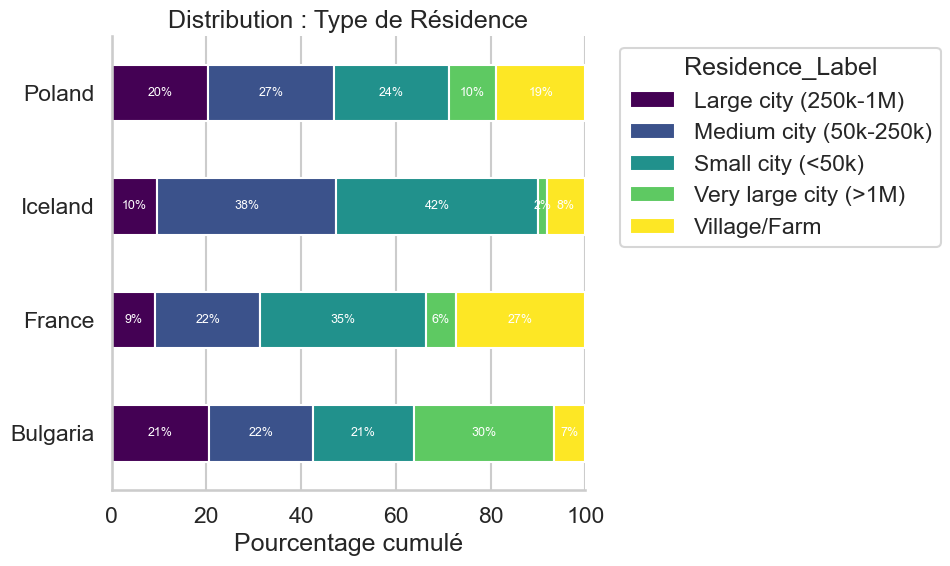


 ANALYSE : Niveau d'Éducation (Education_Label)
>>> Tableau des Pourcentages (%) :
Education_Label  No schooling  Primary  Secondary  University/Higher  \
COUNTRY                                                                
Bulgaria                  0.2      0.3        1.5               59.1   
France                    0.1      0.6       18.8               56.0   
Iceland                   0.1      4.9        9.9               69.8   
Poland                    0.3     10.0       35.5               45.2   

Education_Label  Vocational  
COUNTRY                      
Bulgaria               38.9  
France                 24.6  
Iceland                15.2  
Poland                  9.1  

>>> Tableau des Effectifs (N) :
Education_Label  No schooling  Primary  Secondary  University/Higher  \
COUNTRY                                                                
Bulgaria                    6        8         46               1773   
France                      1       10        316     

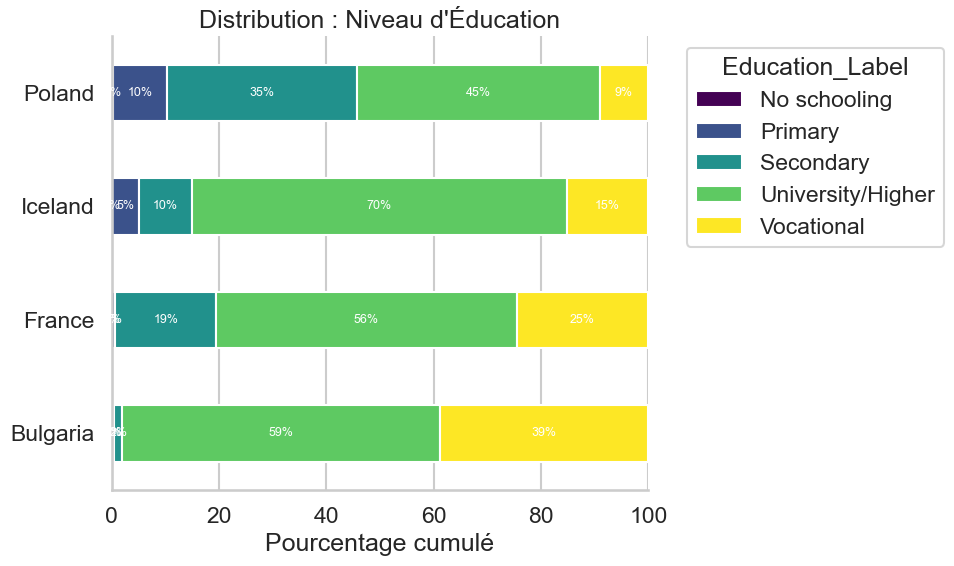


 ANALYSE : Statut Professionnel (Activity_Label)
>>> Tableau des Pourcentages (%) :
Activity_Label  Active  Non-active
COUNTRY                           
Bulgaria          75.9        24.1
France            72.2        27.8
Iceland           72.7        27.3
Poland            74.1        25.9

>>> Tableau des Effectifs (N) :
Activity_Label  Active  Non-active
COUNTRY                           
Bulgaria          2275         723
France            1212         466
Iceland           1051         394
Poland            1155         404


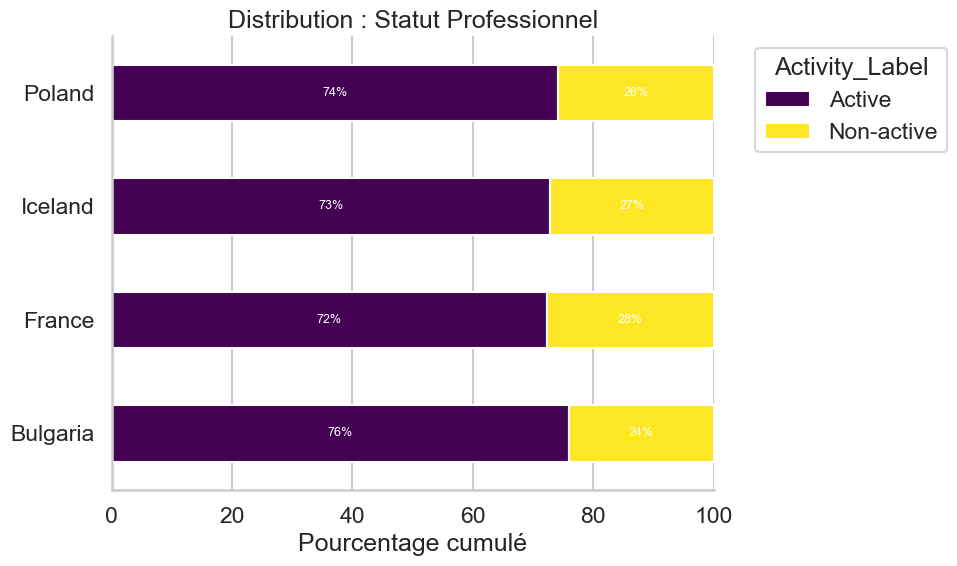


 ANALYSE : classe sociale (Class_Label)
>>> Tableau des Pourcentages (%) :
Class_Label  Blue collar  Business person  Manager/Professional  No answer  \
COUNTRY                                                                      
Bulgaria            22.5              6.4                  23.4       24.1   
France              18.7              5.2                  22.5       27.8   
Iceland             11.6             12.3                  37.9       27.3   
Poland              25.8              3.1                  21.8       25.9   

Class_Label  Other  White collar  
COUNTRY                           
Bulgaria       8.8          14.7  
France         5.3          20.5  
Iceland        0.2          10.7  
Poland         3.7          19.6  

>>> Tableau des Effectifs (N) :
Class_Label  Blue collar  Business person  Manager/Professional  No answer  \
COUNTRY                                                                      
Bulgaria             675              192               

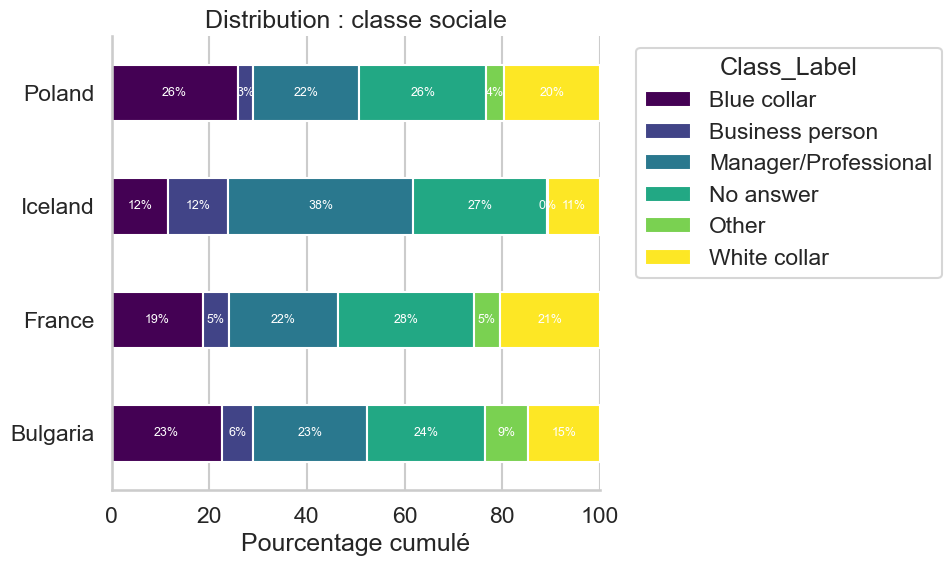


 ANALYSE : Emploi actuel (Demo_Empl)
>>> Tableau des Pourcentages (%) :
Demo_Empl   1.0   2.0  3.0
COUNTRY                   
Bulgaria   87.4  11.1  1.5
France     83.6  14.8  1.7
Iceland    76.8  23.2  0.0
Poland     86.6  10.5  2.9

>>> Tableau des Effectifs (N) :
Demo_Empl   1.0  2.0  3.0
COUNTRY                  
Bulgaria   1989  252   34
France     1013  179   20
Iceland     807  244    0
Poland     1000  121   34


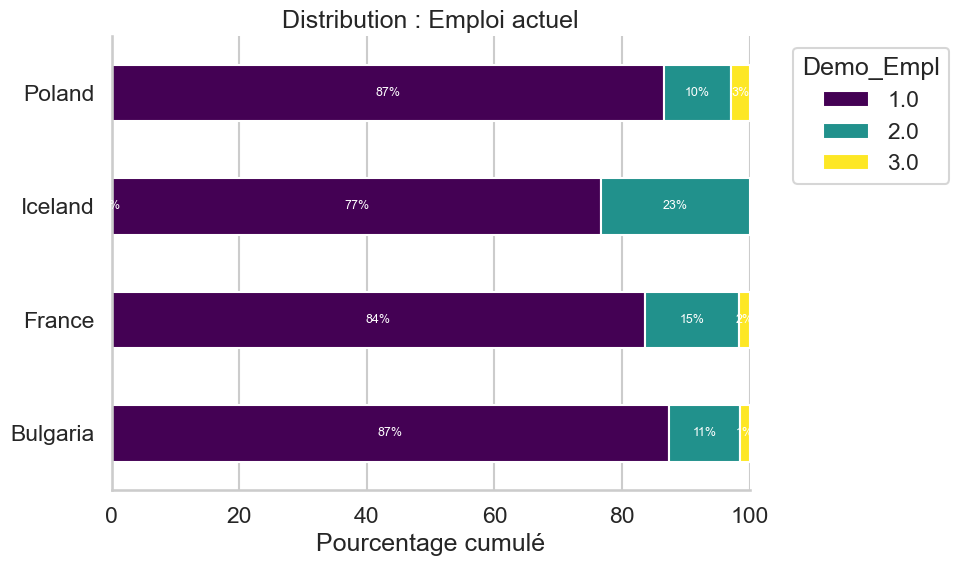

In [32]:
std.analyse_cat(data1, 'Marital_Label', 'Statut Marital')
std.analyse_cat(data1, 'Residence_Label', 'Type de Résidence')
std.analyse_cat(data1, 'Education_Label', "Niveau d'Éducation")
std.analyse_cat(data1, 'Activity_Label', 'Statut Professionnel')
std.analyse_cat(data1, 'Class_Label', 'classe sociale')
std.analyse_cat(data1, 'Demo_Empl', 'Emploi actuel')

Synthese des profils socio-demographiques:

On observe ci-dessus des structures culturelles bien distinctes selon les pays. La Pologne se détache comme le pays le plus « traditionnel », avec une nette majorité de personnes mariées (63 %), là où la France et l'Islande comptent beaucoup plus de célibataires. Géographiquement, c'est la Bulgarie qui surprend par sa polarisation extrême : ses habitants vivent soit dans la capitale et les très grandes villes, soit au village, sans grand entre-deux.

Le niveau d'éducation est un autre facteur de différenciation majeur. L'échantillon islandais est particulièrement instruit (70 % de niveau universitaire), ce qui contraste avec une Pologne dont le socle principal reste l'enseignement secondaire. Cela aura forcément un impact sur l'analyse des comportements de santé, même si le taux d'emploi, lui, est identique partout (environ 75 % d'actifs).


 ANALYSE : Âge des répondants (SD_2)
          Moyenne  Médiane  Ecart-Type    IQR  Min  Max   P10   P90
COUNTRY                                                            
Bulgaria    40.49     41.0       11.61  18.00   18   64  24.0  56.0
France      41.98     42.0       12.84  22.00   18   64  25.0  60.0
Iceland     40.09     38.0       11.65  14.00   18   64  26.0  56.0
Poland      39.91     40.0       12.77  20.25   18   64  22.0  58.0


C:\Users\chris\AppData\Local\Temp\ipykernel_27388\1509569082.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


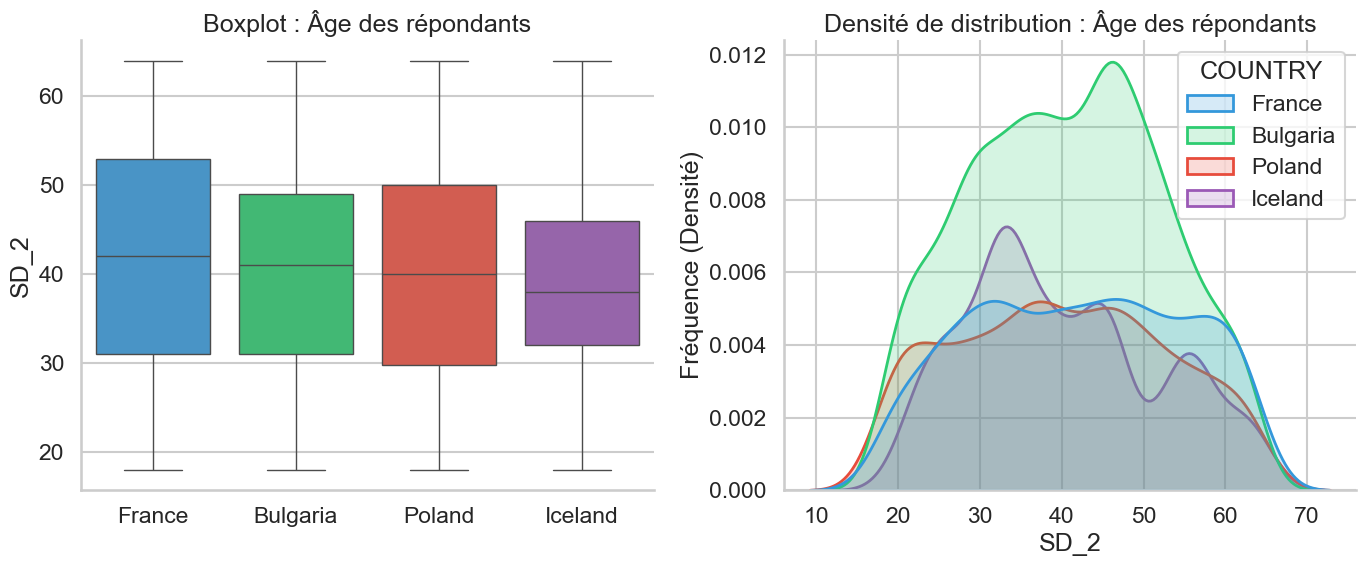


 ANALYSE : Revenu Mensuel (en Euros) (sd_20month_EUR_2020)
          Moyenne  Médiane  Ecart-Type      IQR      Min       Max      P10  \
COUNTRY                                                                       
Bulgaria  1020.52   895.03      587.77   715.56    95.87   2300.85   409.04   
France    4020.07  2925.00     2738.46  3437.50  1500.00   9000.00  1500.00   
Iceland   5053.20  4869.73     2156.25  2252.25  1533.97  10080.35  1533.97   
Poland    1301.35  1175.25      592.81   940.20   264.43   2291.75   587.63   

              P90  
COUNTRY            
Bulgaria  2045.20  
France    9000.00  
Iceland   7304.60  
Poland    2291.75  


C:\Users\chris\AppData\Local\Temp\ipykernel_27388\1509569082.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


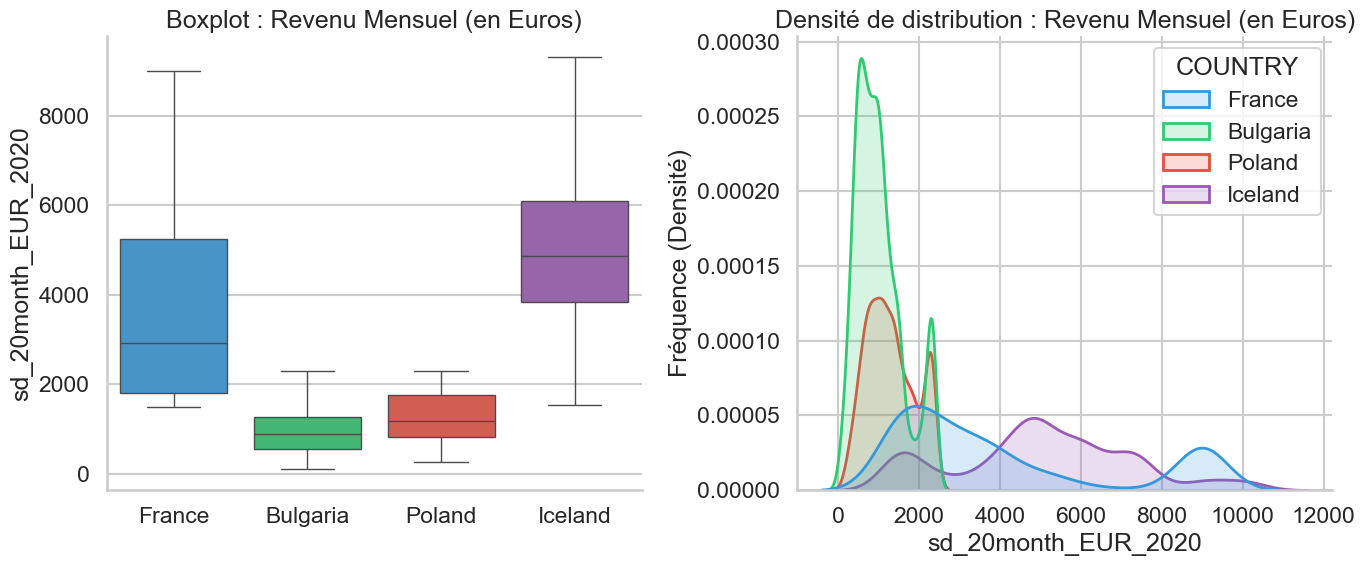

In [ ]:
std.analyse_num(data1, 'SD_2', 'Âge des répondants')
std.analyse_num(data1, 'sd_20month_EUR_2020', 'Revenu Mensuel (en Euros)')

On observe une structure d'age relativement homogene, les échantillons sont parfaitement alignés entre les quatre pays. La moyenne d'âge gravite partout autour de 40-42 ans, avec une couverture stricte de la population active (de 18 à 64 ans). On note une légère nuance pour l'Islande, qui présente une population un peu plus jeune (médiane à 38 ans contre 42 en France) et une densité plus forte sur les trentenaires. Cependant, ces écarts sont minimes. Ainsi, si l'on observe des différences de consommation d'alcool, elles ne seront pas dues à un effet de structure (par exemple, un pays qui serait beaucoup plus "vieux" qu'un autre).

À l'inverse de l'âge, la distribution des revenus mensuels (convertis en euros) illustre le fossé économique entre les pays étudiés. On distingue clairement deux groupes :
-Le groupe "Hauts Revenus" : L'Islande domine largement avec un revenu médian autour de 4 800 €, suivie par la France (médiane à 2 925 €). La France se distingue par une forte inégalité : la moyenne (4 020 €) est bien supérieure à la médiane, tirée par des hauts revenus, ce qui se voit sur l'étalement de la courbe de densité.
-Le groupe "Revenus Modestes" : La Pologne et la Bulgarie présentent des distributions beaucoup plus resserrées et concentrées vers le bas, avec des médianes respectives de 1 175 € et 895 €.

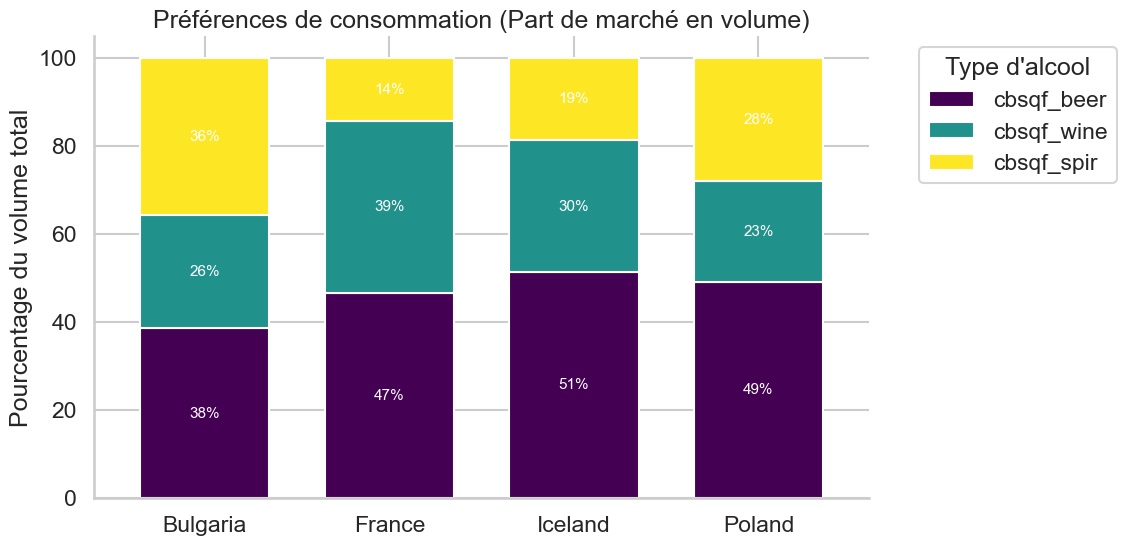

In [22]:
preferences_alcool(data1)


 LIEUX DU BINGE DRINKING (Correction)


C:\Users\chris\AppData\Local\Temp\ipykernel_27388\2075320738.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  moyennes = df.groupby('COUNTRY').apply(lambda x: np.mean(is_regular[x.index])) * 100
C:\Users\chris\AppData\Local\Temp\ipykernel_27388\2075320738.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  moyennes = df.groupby('COUNTRY').apply(lambda x: np.mean(is_regular[x.index])) * 100
C:\Users\chris\AppData

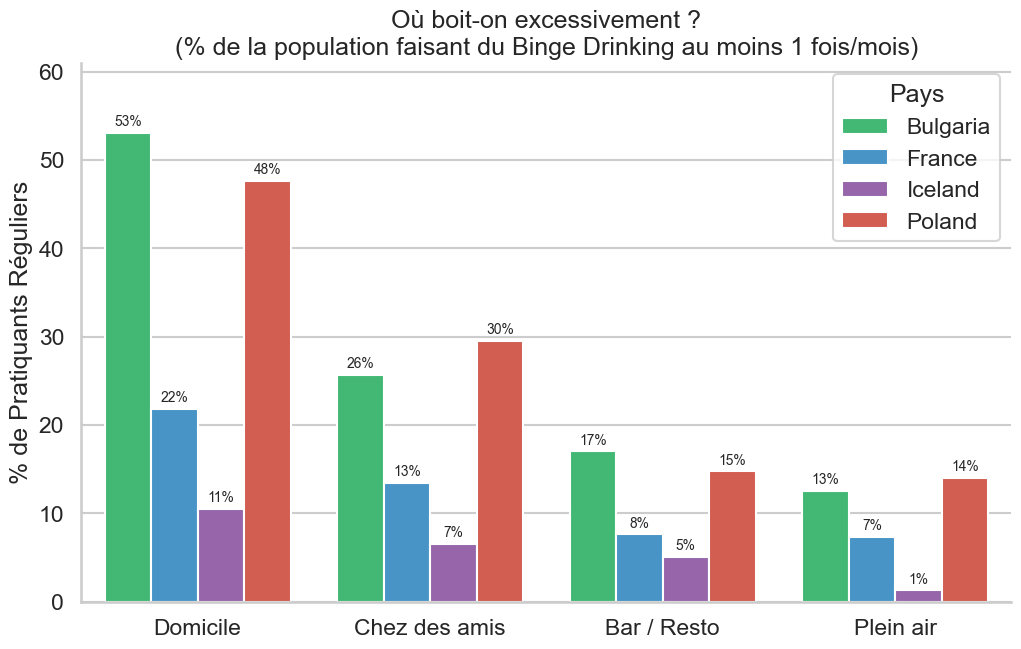

In [ ]:
std.visualisation_lieux(data1)

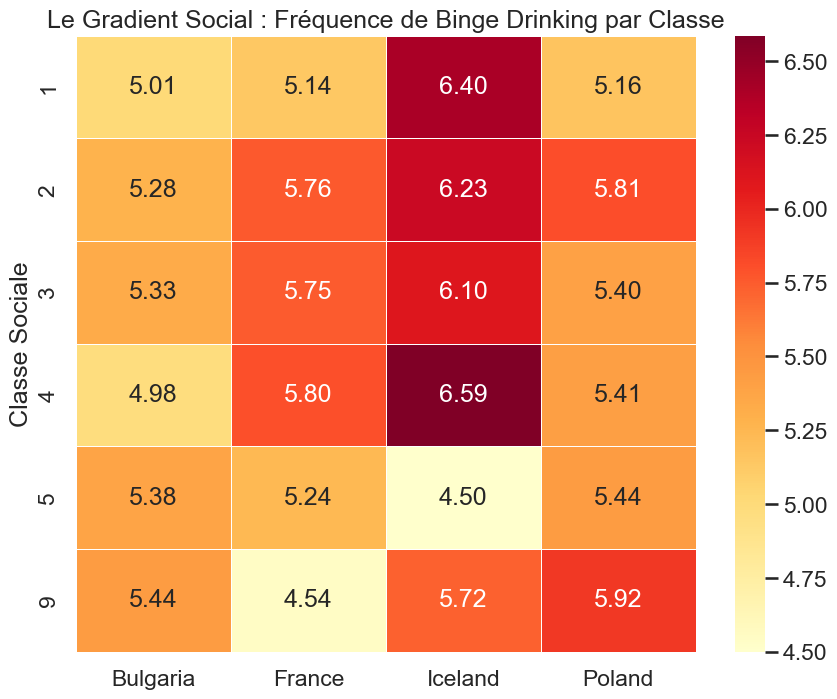

In [ ]:
std.analyse_sociale_croisee(data1)

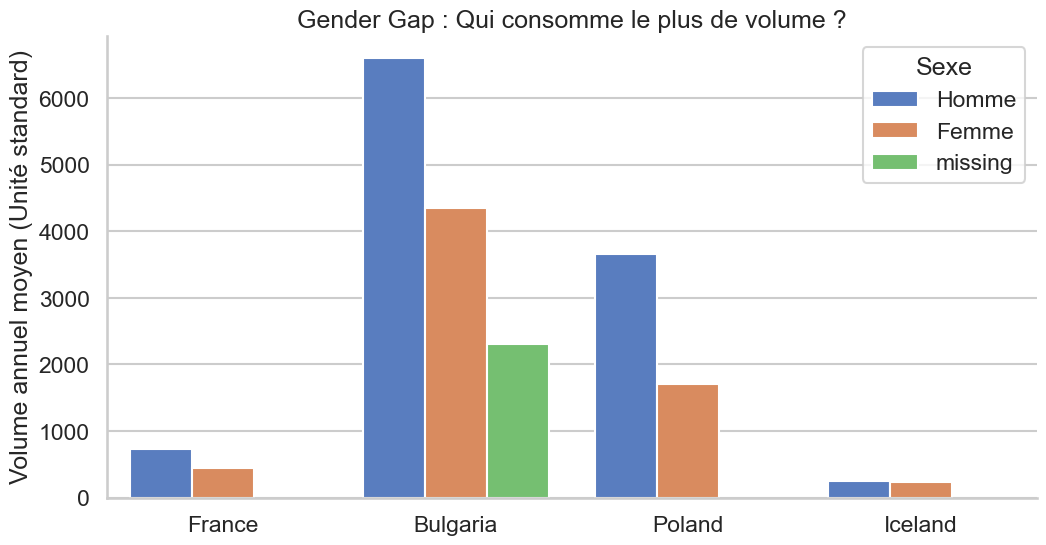

In [ ]:
std.ecart_hommes_femmes(data1)

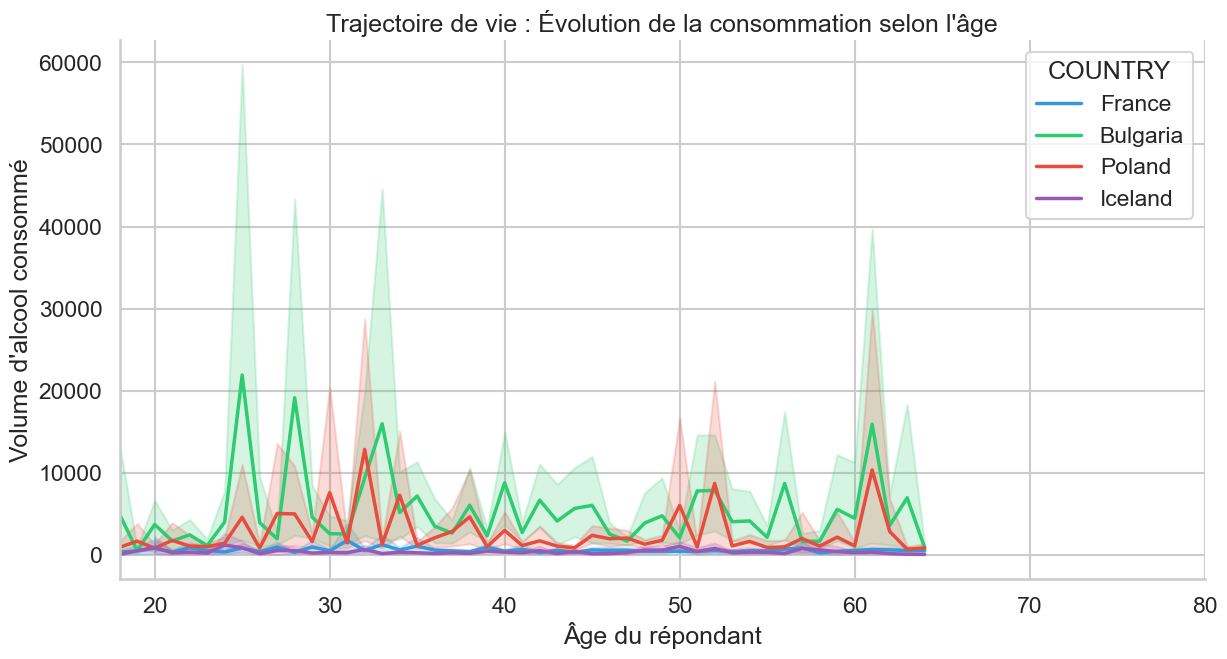

In [ ]:
std.evolution_par_age(data1)


(a) INTENSITÉ ANNUELLE (bsqf_alc)
>>> Indicateurs de distribution :
            mean  median     iqr     p90      p95
COUNTRY                                          
Bulgaria  5429.0   660.1  2020.0  6420.9  14448.4
France     585.7   179.1   555.6  1434.7   2309.1
Iceland    242.6    60.0   181.6   577.3   1133.5
Poland    2627.6   537.3  1302.5  3555.6   6418.6


C:\Users\chris\AppData\Local\Temp\ipykernel_27388\3333722490.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='COUNTRY', y=col_vol, data=sub_df, palette=COULEURS_PAYS, ax=axes[0], showfliers=False)


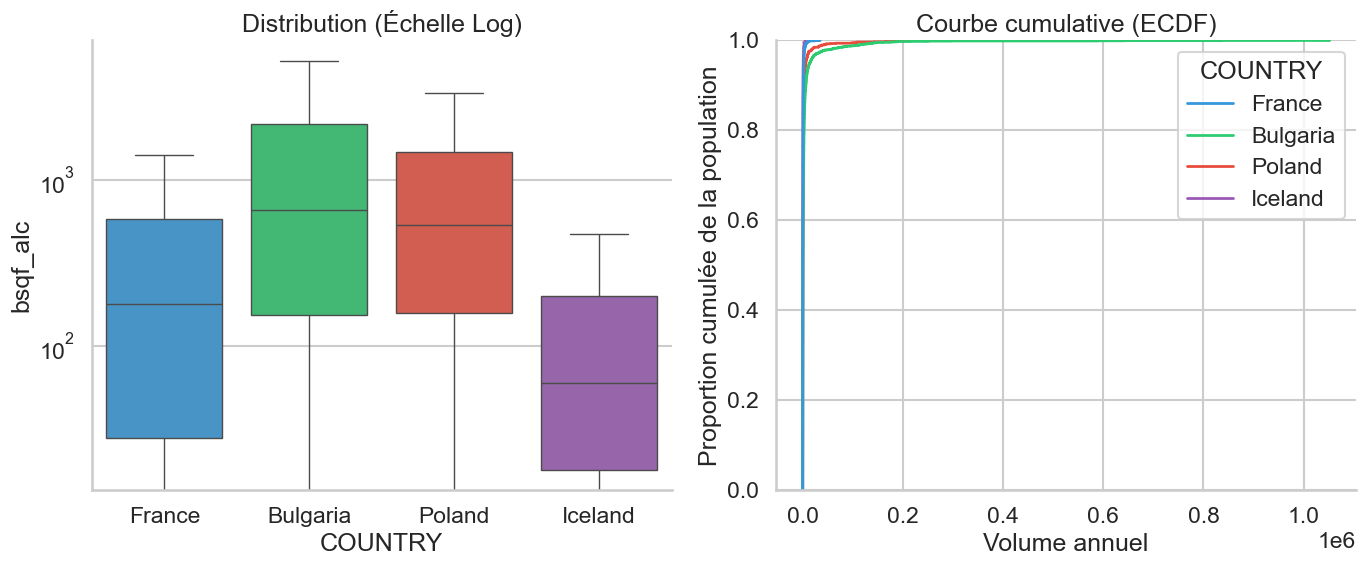

In [ ]:
std.analyse_intensite_annuelle(data1, log_scale=True)

on voit ici que la Bulgarie et la Pologne se distinguent par les médianes de consommation les plus élevées et des distributions étalées vers le haut, signalant une part importante de gros consommateurs. À l'opposé, l'Islande affiche une consommation globale très faible, avec une médiane écrasée vers le bas.


(d-1) FRÉQUENCE BINGE DRINKING (RSOD_2b)
Distribution des fréquences RSOD (%) :
RSOD_Simple  1 - 2 days a week  1 day in a month  2-3 days a month  \
COUNTRY                                                              
Bulgaria                  11.0               7.0              15.1   
France                     8.1               8.0              11.6   
Iceland                    6.8               4.0               8.4   
Poland                    19.3              14.2              15.6   

RSOD_Simple  2-5 days a year  3-4 days a week  5-6 days a week  \
COUNTRY                                                          
Bulgaria                12.7             11.9              7.3   
France                  17.2              6.4              1.1   
Iceland                 12.5              2.5              0.7   
Poland                  14.3              6.1              2.8   

RSOD_Simple  6-11 days a year  Every day  \
COUNTRY                                    
Bulgaria     

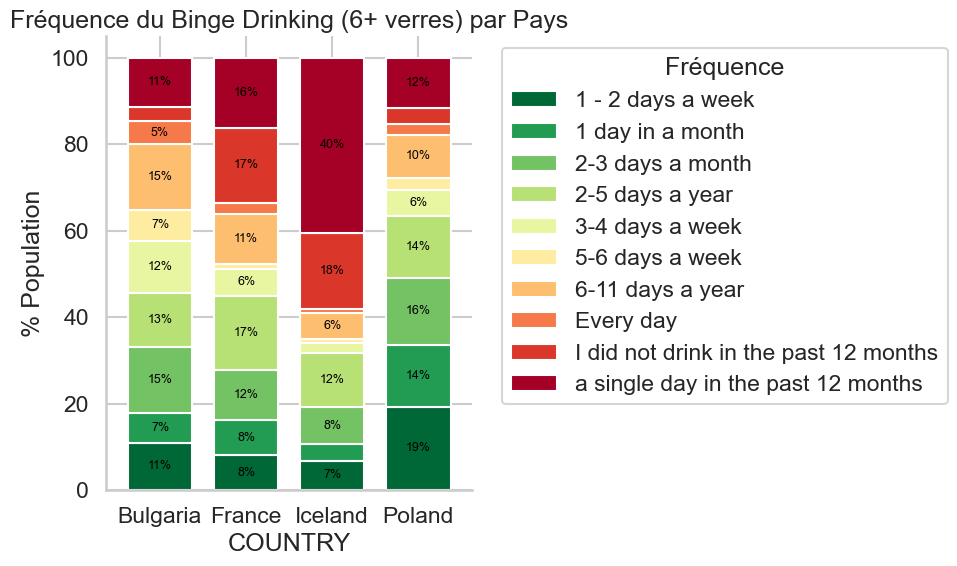

In [ ]:
std.analyse_rsod_frequence(data1)

Ici aussi, on peut voir que la Pologne et la Bulgarie demeurent les pays ou l'on boit le plus frequemment.


(d-2) LIEUX DU BINGE DRINKING (Contextes)


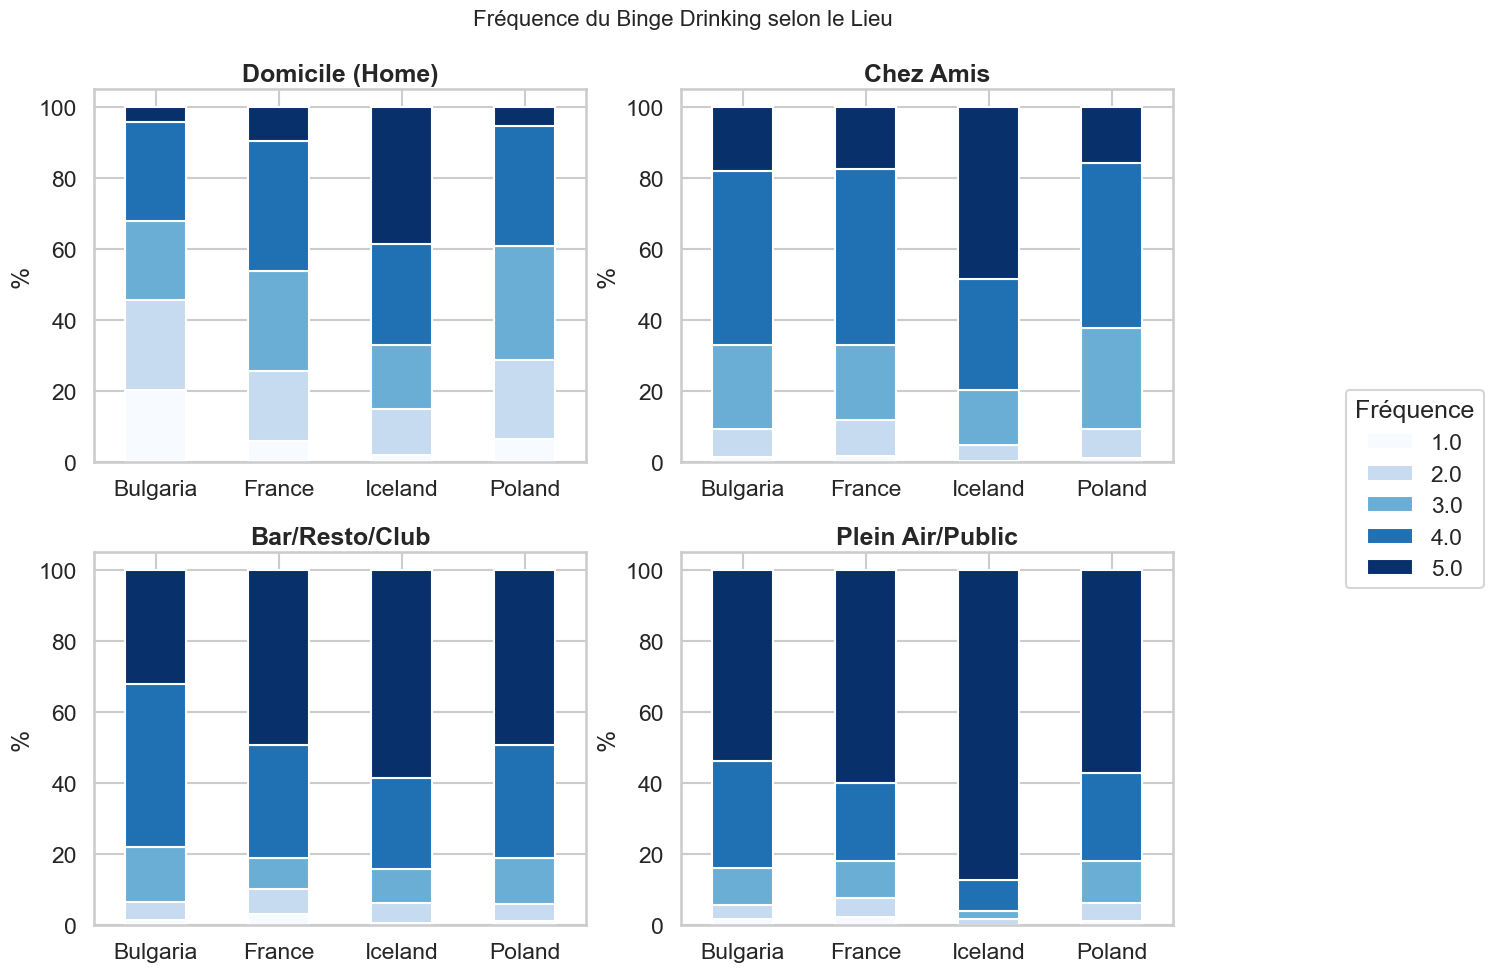

Calcul des Indicateurs de Synthèse...
          % Dominance Domicile (Home > Bar)
COUNTRY                                    
Bulgaria                               54.8
France                                 26.2
Iceland                                15.1
Poland                                 56.0


C:\Users\chris\AppData\Local\Temp\ipykernel_27388\2220814605.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


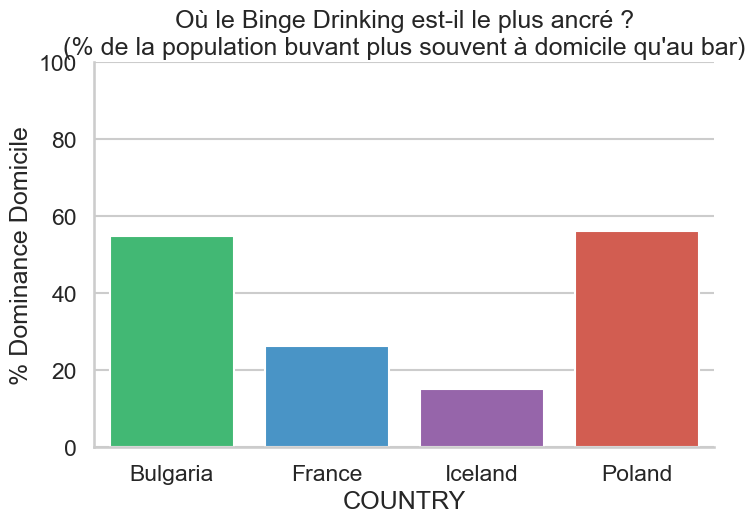

In [ ]:
std.analyse_lieux_rsod(data1)

On voit que les lieux de consommation excessive (Binge Drinking) ne sont pas du tout les mêmes selon le pays.

En Bulgarie et en Pologne, l'ivresse se passe à la maison. Environ 50 % des répondants déclarent faire des excès à domicile au moins une fois par mois. C'est une consommation privée, peut-être liée au coût de l'alcool ou à la culture de l'hospitalité.

En France, le phénomène est beaucoup plus dilué : on boit trop à la maison (22 %), mais aussi chez des amis ou au bar.

A contrario en Islande, le domicile est un lieu de sagesse (seulement 11 % d'excès), ce qui suggère que les Islandais sortent pour faire la fête, ou que le contrôle social à la maison est plus fort.


(c) COMPOSITION DU PANIER (Mix Alcool)
>>> Mix Moyen (%) par Pays :
          Share_Beer  Share_Wine  Share_Spir
COUNTRY                                     
Bulgaria        37.1        31.2        31.7
France          43.8        42.6        13.6
Iceland         47.2        35.0        17.8
Poland          49.9        26.8        23.3


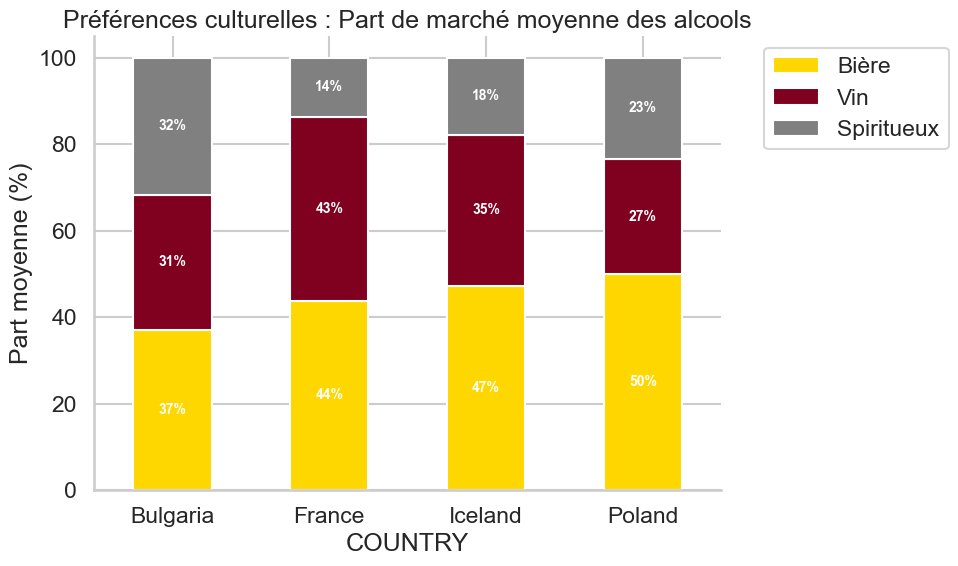

In [ ]:
std.analyse_composition(data1)

En matiere de type d'alcool conseommé, la France reste incontestablement le pays du vin, qui représente 43 % du volume d'alcool ingéré, loin devant les autres pays. La Pologne (50 %) et l'Islande (47 %) en revanche sont des terres de bière. La Bulgarie quant a elle est le seul pays où les spiritueux (alcools forts) occupent une place aussi massive (32 % du marché), talonnant la bière.